<a href="https://colab.research.google.com/github/mille055/AIPI540_individual_project/blob/main/notebooks/Main_abd02_28_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
from nbdev.showdoc import *
from dicomtools.basics import *
from dicomtools.series import *
from dicomtools.core import *
from dicomtools.series.preproc import *
from dicomtools.series.train import *
from dicomtools.series.predict import *
from dicomtools.series.find import *
from dicomtools.series.annotate import *
from dicomtools.data import *
import numpy as np
import pydicom
from sklearn.model_selection import KFold, GroupKFold, cross_val_score, cross_validate, GroupShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, plot_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt  
#from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score


import tensorflow as tf
#!pip3 install tensorflow_decision_forests --upgrade
#import tensorflow_decision_forests as tfdf
#print("Found TensorFlow Decision Forests v" + tfdf.__version__)

%matplotlib inline
from pprint import pprint
import pickle
from datetime import datetime


In [ ]:
print(pydicom.__version__)

2.1.2


In [ ]:
!pip show scikit-learn

Name: scikit-learn
Version: 0.24.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /Users/cmm/opt/anaconda3/envs/MRI_project2/lib/python3.8/site-packages
Requires: scipy, joblib, threadpoolctl, numpy
Required-by: fastai, dicomtools


This project utilizes the `pydicom` and `fastcore` libraries. It borrows ideas (and some code) from the `fastai.medical.imaging` library ([source](https://github.com/fastai/fastai/blob/master/fastai/medical/imaging.py)).

The metadata preprocessing and series selection algorithm are recreated from the paper by Gauriau et al. (_reference below_), in which a Random Forest classifier is trained to predict the sequence type (e.g. T1, T2, FLAIR, ...) of series of images from brain MRI. Such a tool may be used to select the appropriate series of images for input into a machine learning pipeline.

> _Reference:_ Gauriau R, et al. Using DICOM Metadata for Radiological Image Series Categorization: a Feasibility Study on Large Clinical Brain MRI Datasets. _Journal of Digital Imaging_. 2020 Jan; 33:747–762. ([link to paper](https://link.springer.com/article/10.1007/s10278-019-00308-x))

In [ ]:
#look at directory and provide paths and filenames


data_path = ('Abdominal MRI data')

labels_file_path = ('labels_chad_modified-reduceUnk.txt')
labels_columns = ['patientID', 'exam', 'series', 'label_code']
filename_columns = ['Parent_folder', 'patientID', 'exam', 'series']
r_seed=42

saved_train_file = 'MRI_abd_train.pkl'
saved_test_file = 'MRI_abd_test.pkl'
saved_val_file = ''

folder_saved_models = 'Saved_models'
folder_archieved_dataframes = 'Archived_dataframes'
model_filename = 'pkl_model'+datetime.now().strftime("%Y%m%d")+'.pkl'

print(model_filename)


pkl_model20230228.pkl


In [ ]:
## utilities ##

#change the series and patientID values to the proper format
def format_series_ID(df):
    df1=df.copy()
    df1['series']=df1['series'].apply(lambda x: str(x).replace(' ', ''))
    df1['patientID']=df1['patientID'].astype(int).astype(str)
    
    return df1

#extract labels, expand the filename into separate columns, get rid of leading 0's in patientID, and remove whitespace in the series to match the dicom dataset
def extract_expand_format_labels(df, filename_cols = ['parent folder', 'patientID', 'exam', 'series']):
    df1=df.copy()
    labels_extracted=extract_labels(df1)
   
    labels_expanded=expand_filename_into_columns(labels_extracted, filename_cols)
    labels_expanded = format_series_ID(labels_expanded)
    
    return labels_expanded

def convert_labels_from_file2(label_df, label_map = abd_label_dict):
    
    labels=label_df.copy()
    print(label_map['3']['short'])
    labels['GT label'] = labels['label_code'].astype(str).apply(lambda x: label_map[x]['short'])
    labels['GT plane'] = labels['label_code'].astype(str).apply(lambda x: label_map[x]['plane'])
    labels['GT contrast'] = labels['label_code'].astype(str).apply(lambda x: label_map[x]['contrast'])
    labels['patientID'] = labels['patientID'].astype(str)

    return labels
    
def prepare_dataframe(df, labelfile, labelmap = abd_label_dict_updated, filenamecols = ['parent folder', 'patientID', 'exam', 'series'], labelcols = ['patientID', 'exam', 'series', 'label_code'], mergecols=['patientID', 'exam', 'series']):
    df1=df.copy()
    df1=preprocess(df1)
    df1=expand_filename_into_columns(df1, cols = filenamecols+['filename'])
    df1=format_series_ID(df1)
  
    labels_from_extraction=extract_expand_format_labels(df1)
    GT_labels=labels_from_file(labelfile, labelcols)
   
    GT_labels_converted = convert_labels_from_file2(GT_labels, labelmap)
    #print(GT_labels_converted.head())
    df_all_labels = labels_from_extraction.merge(GT_labels_converted, on = mergecols)
    df1 = df1.merge(df_all_labels, on = mergecols)
        
    return df1

#return list of unique patient ID in a dataframe
def patientID_list(df):
    return df.patientID.unique()

#print list of labels for a given dictionary
def print_label_list(dict):
    label_list=[]
    for idx in range(32):
        label_list.append((idx, (dict[(str(idx))]['short']), dict[(str(idx))]['plane']))
        #label_list[index] = abd_label_dict[str(index)]

    pprint(label_list)
    
def label_value_counts(df):
    return df['label_code'].value_counts()

#merge several labels into one with new column, default is contrast pooling. send list of tuples where first is list of columns to merge and second is new value
def merge_series(df, mergelisttuples=[([2,3,4,5,6, 12, 13, 16,23,29], 30)], old_label = 'label_code', new_label = 'con_label_code'):
    df1=df.copy()
    df1[new_label]=df1[old_label]
    for merge in mergelisttuples:
        df1.loc[df1[old_label].isin(merge[0]), new_label] = merge[1]
    
    #df1.loc[df1['label_code']==postcon_ax_new, 'GT label'] = 'T1 post con'
    #df1.loc[df1['label_code']==postcon_cor_new, 'GT label'] = 'T1 post con'
    return df1

#exclude cases from the list for a given column
def exclude_cases(df, excluded_list, label_col='label_code'):
    df1=df.copy()
    df_exclude = df1.loc[~df1[label_col].isin(excluded_list)]
    
    return df_exclude
        

#view prediction and GT code
def compare_prediction_df(df2, predictions, cols, key_label):

    prediction_comp = pd.DataFrame()
    prediction_comp[cols] = df2[cols]
    prediction_comp['predictions']=(predictions).astype(int)
    
    prediction_comp['GT label'] = prediction_comp[key_label].astype(str).apply(lambda x: abd_label_dict[x]['short'])
    prediction_comp['prediction label'] = prediction_comp['predictions'].astype(str).apply(lambda x: abd_label_dict[x]['short'])
 
    #prediction_comp['sequence description']=df2['SeriesDescription_x']
        
    return prediction_comp

#show predictions for a given label code on after predictions merged
def prediction_accuracy_by_code(df, code):
    df1=df.copy()
    correct_df=df1.loc[(df1['label_code']==df1['predictions'])]
    incorrect_df=df1.loc[(df1['label_code']!=df1['predictions'])]
    #print(correct_df)
    correct=correct_df[(correct_df['predictions']==code)].shape[0]
    incorrect=incorrect_df[(incorrect_df['predictions']==code)].shape[0]
    total=df1[df1['label_code']==code].shape[0]
    if total!=0:
        print ('label code',code,'correct:', correct, 'total', total, 'percent', (correct/total))
    return correct, total

# show a table of the predictions for the different codes
def prediction_table(df, values):
    df1=df.copy()
    prediction_list=[]
    for index in values:
        pred_corr_total=prediction_accuracy_by_code(df1, index)
        prediction_list.append(pred_corr_total)
        
    return prediction_list

#explore train.fit and kgroupcross validation
def train_setup_abdomen_cross(df, cols=['patientID','exam','series'], need_preproc=False, need_labels=False):

    if need_preproc:
        df1=preprocess(df)
        
    else:
        df1=df.copy()
    
    if need_labels:

        labels = extract_labels(df1)
        df1 = df1.merge(labels, on=cols)
 
    length = df1.shape[0]

    gkf = GroupKFold(n_splits=5)
    for train_set, val_set in gkf.split(df1, groups=df1['patientID']):
        #print(train_set, len(train_set), train_set.dtype)
        #print(df1.iloc[train_set])
        train_df, val = df1.iloc[train_set], df1.iloc[val_set]
        y, y_names = train_df['label_code'],train_df['GT label']
        
        clf_gkf = train_fit(train_df, y, features=preproc._features, fname='cross_from_notebook.skl' )
        scores = cross_validate(clf_gkf, train_df[preproc._features], y, scoring=['precision_macro', 'recall_macro'])
        print(scores)
    #return train, val, y, y_names

    
#grid search for hyperparameters
def train_fit_parameter_trial(train, y, features, fname='model-run.skl'):
    "Train a Random Forest classifier on `train[features]` and `y`, then save to `fname` and return."
    clf = RandomForestClassifier(n_jobs=2, random_state=0)
    clf.fit(train[features], y)
    print('Parameters currently in use:\n')
    pprint(clf.get_params())
    
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 20)]
# Number of features to consider at every split
    max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 660, num = 10)]
    max_depth.append(None)
# Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
    min_samples_leaf = [2, 4, 8]
# Method of selecting samples for training each tree
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
    
    clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
    clf_random.fit(train[features], y)
    opt_clf = clf_random.best_estimator_
    pprint(clf_random.best_params_)
    pickle.dump(opt_clf, open(fname, 'wb'))
    #dump(clf_random, fname)
    return opt_clf


## create probability and top 3 df for merging with other data
def create_probs_and_top3(model, df, prediction_df, features=preproc._features, cols=['label_code']):
    df1=df.copy()
    prob_list=(model.predict_proba(df1[features]))
    top3_list=np.zeros((prob_list.shape[0],3), dtype=int)
    for index in range(prob_list.shape[0]):
        prob_list[index,0]=prob_list[index].max()
        
        top3_list[index] = model.classes_[np.argsort(prob_list)[:,:-4:-1]][index]
       
    prob_list=prob_list[:,0]
    
    prediction_df1 = prediction_df.copy()
    prediction_df1['probability'], prediction_df1[['top label', 'second label', 'third label']] = prob_list, top3_list
    prediction_df1.loc[(prediction_df1['label_code']==prediction_df1['predictions'])]
    
    return prediction_df1


## also try to get predictions from series descriptions?

t1_ = re.compile(r't1')
t1_in_ = re.compile(r'dixon_in')
t1_out_ = re.compile(r'opp')
water_ = re.compile(r'dixon_W|water')
fat_ = re.compile(r'dixon_F|fat')
pv_ = re.compile(r'portal')
eq_ = re.compile(r'equilibrium')
art_ = re.compile(r'art|arterial|dyn|early')
delayed_ = re.compile(r'delay|15|20|hepatobiliary')

t2_ = re.compile(r't2|haste')

adc_ = re.compile(r'adc|apparent|diff_adc')

dwi_ = re.compile(r'diff|dwi|trace')
mra_ = re.compile(r'mra|angio|tof|mip|mrv')
loc_ = re.compile(r'loc|scout')
other_ = re.compile(r'ciss|fiesta|stir|pd|cube|pc')

def find_seq_to_label_code_(sd):
    if t1_.search(sd):
        if t1_in_.search(sd): return '14'
        if t1_out_.search(sd): return '19'
        if water_.search(sd): return '25'
        if fat_.search(sd): return '11'    
        if pv_.search(sd): return '23'
        if eq_.search(sd): return '16'
        if art_.search(sd): return '2'
        if delayed_.search(sd): return '12'
        else: return '25'
    if t1_in_.search(sd): return '14'
    if t1_out_.search(sd): return '19'
    if water_.search(sd): return '25'
    if fat_.search(sd): return '11'    
    if pv_.search(sd): return '23'
    if eq_.search(sd): return '16'
    if art_.search(sd): return '2'
    if delayed_.search(sd): return '12'

    if t2_.search(sd): return '9'
    if dwi_.search(sd): return '8'
    if adc_.search(sd): return '0'
    #if _eadc.search(sd): return 'dwi'
    if mra_.search(sd): return '2'
    if loc_.search(sd): return '17'
    if other_.search(sd): return '1'
 
    return -1



#adds the predicted label on heuristics on series description
def add_textual_label(df, col_name='SeriesDescription_y', text_code_col='textual_label_code'):
    df1=df.copy()
    test_x=[]
    for item in df1[col_name]:
        test_x.append(find_seq_to_label_code_(item))
    df1[text_code_col]=test_x
    return df1


def ignore_trivial_features(df, featurelist, verbose=False):
    df1 = df.copy()
    feats = []
    for feat in featurelist:
        
        if len(df1[feat].unique())==1:
            feats.append(feat)
    if verbose:
            print('feats to drop', feats, len(feats))
    return feats

In [ ]:
#get dataframes from saved pickled files, working = train + validation, dev is copy of train+validation to train before test


working_df = pd.read_pickle(saved_train_file)

dev_df = working_df.copy()
test_df = pd.read_pickle(saved_test_file)

image_preds_df = pd.read_pickle('image_data_with_label082221.pkl')

display(dev_df)
#get pixel based classification
dev_df = dev_df.merge(image_preds_df[['prob_avg', 'patientID', 'series', 'img_label_code','model_name']], how='left', on=['patientID', 'series'])
test_df = test_df.merge(image_preds_df[['prob_avg', 'patientID', 'series', 'img_label_code','model_name']], how='left', on=['patientID', 'series'])
#results_df.drop(['series_path'], axis=1, inplace=True)

display(dev_df[['prob_avg', 'patientID', 'series', 'img_label_code','model_name']])

,ImageType,SOPClassUID,SeriesDescription,ContrastBolusAgent,BodyPartExamined,ScanningSequence,SequenceVariant,ScanOptions,MRAcquisitionType,AngioFlag,...,ImageOrientationPatient,PhotometricInterpretation,PixelSpacing,fname,TriggerTime,InversionTime,Parent_folder,patientID,exam,series
0,"[DERIVED, PRIMARY, DIFFUSION, TRACEW, DIS2D]",MR Image Storage,ax diff_TRACEW,Multihance,ABDOMEN,EP,"[SK, SP]","[PFP, SFS]",2D,N,...,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[0.9375, 0.9375]",Abdominal MRI data/104/exam1/18 (35-68)/0038.dcm,NaN,NaN,Abdominal MRI data,104,exam1,18(35-68)
1,"[DERIVED, PRIMARY, DIFFUSION, TRACEW, DIS2D]",MR Image Storage,ax diff_TRACEW,Multihance,ABDOMEN,EP,"[SK, SP]","[PFP, SFS]",2D,N,...,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[0.9375, 0.9375]",Abdominal MRI data/104/exam1/18 (1-34)/0010.dcm,NaN,NaN,Abdominal MRI data,104,exam1,18(1-34)
2,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax equilibrium,Multihance,ABDOMEN,GR,"[SP, OSP]","[PFP, FS]",3D,N,...,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[0.703125, 0.703125]",Abdominal MRI data/104/exam1/20/0010.dcm,NaN,NaN,Abdominal MRI data,104,exam1,20
3,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax haste bh,NaN,ABDOMEN,SE,"[SK, SP, OSP]","[PFP, SAT2, SFS]",2D,N,...,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[1.5625, 1.5625]",Abdominal MRI data/104/exam1/9/0010.dcm,NaN,NaN,Abdominal MRI data,104,exam1,9
4,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax t2 triggerred,NaN,ABDOMEN,SE,"[SK, SP]","[PFP, SAT2, FS]",2D,N,...,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[1.5625, 1.5625]",Abdominal MRI data/104/exam1/11/0010.dcm,NaN,NaN,Abdominal MRI data,104,exam1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2210,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,cor haste,NaN,ABDOMEN,SE,"[SK, SP, OSP]",PFP,2D,N,...,"[1, 0, 0, 0, 0, -1]",MONOCHROME2,"[1.5625, 1.5625]",Abdominal MRI data/094/exam1/3/0010.dcm,NaN,NaN,Abdominal MRI data,94,exam1,3
2211,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax dyn,Multihance,ABDOMEN,GR,"[SP, OSP]","[PFP, FS]",3D,N,...,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[0.78125, 0.78125]",Abdominal MRI data/094/exam1/12/0010.dcm,NaN,NaN,Abdominal MRI data,94,exam1,12
2212,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax dyn,Multihance,ABDOMEN,GR,"[SP, OSP]","[PFP, FS]",3D,N,...,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[0.78125, 0.78125]",Abdominal MRI data/094/exam1/13/0010.dcm,NaN,NaN,Abdominal MRI data,94,exam1,13
2213,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax dixon_opp,NaN,ABDOMEN,GR,SP,"[PFP, SAT2]",3D,N,...,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[1.5625, 1.5625]",Abdominal MRI data/094/exam1/5/0010.dcm,NaN,NaN,Abdominal MRI data,94,exam1,5


,prob_avg,patientID,series,img_label_code,model_name
0,"[0.0015035595, 0.00013818343, 0.0634858, 0.008...",104,18(35-68),8,2d_inception_prediction
1,"[0.0015379599, 8.472917e-05, 0.068862244, 0.00...",104,18(1-34),9,2d_inception_prediction
2,"[9.1864985e-07, 3.144006e-05, 0.31217778, 0.00...",104,20,2,2d_inception_prediction
3,"[1.2058763e-05, 2.1075539e-06, 2.5486854e-05, ...",104,9,9,2d_inception_prediction
4,"[8.9258054e-07, 4.1016145e-07, 9.1695656e-05, ...",104,11,9,2d_inception_prediction
...,...,...,...,...,...
1765,"[2.763423e-07, 1.8852224e-05, 1.8843992e-05, 1...",94,3,7,2d_inception_prediction
1766,"[5.638925e-09, 1.0226829e-09, 0.96166295, 0.03...",94,12,2,2d_inception_prediction
1767,"[6.1219663e-07, 4.6967133e-07, 0.9265961, 0.06...",94,13,2,2d_inception_prediction
1768,"[1.506263e-12, 9.957016e-11, 1.0790797e-09, 5....",94,5,19,2d_inception_prediction


In [ ]:
#loading in the predicated labels from the pretrained ResNet50 from 1/27/23
img_label_2 = pd.read_csv('test_preds012723.csv')
img_label_2.rename(columns={'predictions':'img_label_code_2', 'probs':'probs_2'}, inplace=True)
#img_label_2.series = img_label_2.series.astype('int64')
img_label_2.patientID = img_label_2.patientID.astype('str')


In [ ]:
img_label_2

,Unnamed: 0,label,patientID,series,file_info,img_label_code_2,probs_2
0,0,8,102,16(1-40),/volumes/cm7/Abdominal_MRI_dataset_split/test/...,8,[2.1694798e-06 9.1904285e-06 9.7151951e-06 2.8...
1,1,8,102,16(41-80),/volumes/cm7/Abdominal_MRI_dataset_split/test/...,8,[4.0775381e-06 7.2287630e-06 2.0545979e-06 2.9...
2,2,16,102,18,/volumes/cm7/Abdominal_MRI_dataset_split/test/...,23,[3.8694096e-04 4.7828564e-03 4.4627660e-03 8.6...
3,3,3,102,11,/volumes/cm7/Abdominal_MRI_dataset_split/test/...,2,[2.0692883e-05 5.1342748e-04 8.1311369e-01 1.5...
4,4,25,102,7,/volumes/cm7/Abdominal_MRI_dataset_split/test/...,25,[2.0147429e-06 9.4190138e-05 3.4986053e-05 1.1...
...,...,...,...,...,...,...,...
441,441,8,58,16(1-36),/volumes/cm7/Abdominal_MRI_dataset_split/test/...,8,[3.59361979e-06 1.27407675e-05 1.66060054e-05 ...
442,442,7,58,2,/volumes/cm7/Abdominal_MRI_dataset_split/test/...,7,[3.86286771e-08 3.99122229e-07 4.59349137e-09 ...
443,443,2,58,13,/volumes/cm7/Abdominal_MRI_dataset_split/test/...,2,[2.15449674e-07 6.85270288e-06 9.96157229e-01 ...
444,444,14,58,5,/volumes/cm7/Abdominal_MRI_dataset_split/test/...,14,[4.63816832e-07 2.94905271e-06 3.70623957e-06 ...


In [ ]:
##list of training and test dataset patientID
train_list = dev_df.patientID.unique()
test_list = test_df.patientID.unique()
print(sorted((train_list).astype('int')), len(train_list), '\n', sorted((test_list).astype('int')), len(test_list))

[0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 72, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 93, 94, 95, 96, 98, 100, 101, 103, 104] 84 
 [5, 9, 15, 16, 22, 24, 28, 46, 49, 58, 69, 71, 73, 74, 78, 87, 91, 92, 97, 99, 102] 21


In [ ]:
#exploring possible scanoptions vlues
#scanoptions_list = dev_df.ScanOptions.to_list()
#scanoptions = {x for l in scanoptions_list for x in l}
#scanoptions

In [ ]:
def prepare_df(df, image_df, exclude_list = [1, 22, 26, 21, 29], train_filename = 'prepared_train_df.pkl', test_filename = 'prepared_test_df.pkl'):
    df1 = df.copy()
    df1 = prepare_dataframe(df1, labels_file_path, labelmap = abd_label_dict_updated, filenamecols = filename_columns)
    df1['original_label_code'] = df1['label_code']
    df1 = exclude_cases(df1, excluded_list = exclude_list)
    df1 = merge_series(df1)
    df1 = merge_series(df1, [([7, 28],9),([30],25), ([10], 8), ([15], 14), ([20], 19)], 'con_label_code', 'MB_label_code')
    df1 = df1.merge(image_preds_df, on=['patientID', 'series'])
    df1 = df1.rename({'img_label_code':'pixel_label_code'}, axis=1)
    df1 = df1.drop(columns=['series_path','model_name'])
    df1 = add_textual_label(df1)
    df1['ap_label_code'] = df1['original_label_code']
    df1['ap_label_code'] = df1['ap_label_code'].apply(lambda x: 2 if x in [3,4] else x)
    df1['con_label_code'] = df1['original_label_code']
    df1['con_label_code'] = df1['con_label_code'].apply(lambda x: 30 if x in [2,3,4,5,6, 12,13,16,23,29] else x) 
    df1['con_label_code'] = df1['con_label_code'].apply(lambda x: 9 if x in [7,28] else x)
  
    df1['pixel_label_code'] = df1['pixel_label_code'].astype('int')
    df1['original_label_code'] = df1['original_label_code'].astype('int')
    
    #make pixel ap GT label_code 
   
    df1['pixel_ap_label_code'] = df1['pixel_label_code']
    df1['pixel_ap_label_code'] = df1['pixel_ap_label_code'].apply(lambda x: 2 if x in [3,4] else x)
   
    return df1

In [ ]:
#after 1/8/2023 the dataframes contain ap_label_coee and pixel_ap_label_code
#after 2/28/23 the dataframes also contin con_label_code
X_train = prepare_df(dev_df, image_preds_df)
X_test = prepare_df(test_df, image_preds_df)
X_train.to_pickle('X_train02282023.pkl')
X_test.to_pickle('X_test02282023.pkl')


Preprocessing metadata for Random Forest classifier.


/Users/cmm/opt/anaconda3/envs/MRI_project2/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Computing planes of imaging from `ImageOrientationPatient`.
Extracting candidate labels from `SeriesDescription`.
Detecting contrast from `SeriesDescription` and `ContrastMediaAgent`.
early_arterial
Preprocessing metadata for Random Forest classifier.
Computing planes of imaging from `ImageOrientationPatient`.
Extracting candidate labels from `SeriesDescription`.

/Users/cmm/opt/anaconda3/envs/MRI_project2/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)



Detecting contrast from `SeriesDescription` and `ContrastMediaAgent`.
early_arterial


In [ ]:
#if already saved preppped dataframes and want to load in:
xtrainfile= 'X_train02282023.pkl'
xtestfile = 'X_test02282023.pkl'

X_train = pd.read_pickle(xtrainfile)
X_test = pd.read_pickle(xtestfile)
X_test

,fname_x,StudyInstanceUID,SeriesInstanceUID,SeriesNumber,SeriesDescription_x,AcquisitionNumber,InstanceNumber,ImageOrientationPatient,MRAcquisitionType,AngioFlag,...,GT plane,GT contrast,original_label_code,con_label_code,MB_label_code,prob_avg,pixel_label_code,textual_label_code,ap_label_code,pixel_ap_label_code
0,Abdominal MRI data/102/exam1/16 (1-40)/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.0428166884534776243534...,16,ax diff_TRACEW,1.0,10,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,8,8,8,"[3.1284948e-05, 1.6915199e-05, 0.0001322235, 1...",9,8,8,9
1,Abdominal MRI data/102/exam1/16 (41-80)/0073.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.0428166884534776243534...,16,ax diff_TRACEW,1.0,73,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,8,8,8,"[1.1402206e-05, 3.274956e-08, 6.8182663e-07, 2...",9,8,8,9
2,Abdominal MRI data/102/exam1/18/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.3046323768673003518430...,18,ax equilibrium new,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,1,16,30,25,"[7.485561e-08, 6.9257175e-07, 0.07679371, 0.00...",23,16,16,23
3,Abdominal MRI data/102/exam1/11/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.2688855248684316807267...,11,ax dyn new,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,1,3,30,25,"[1.7049644e-10, 1.5578018e-09, 0.6867239, 0.31...",2,2,2,2
4,Abdominal MRI data/102/exam1/7/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.5152335108081034426775...,7,ax dixon_W,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,0,25,25,25,"[1.2793084e-09, 5.4996406e-08, 4.0720603e-05, ...",25,25,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,Abdominal MRI data/058/exam1/16 (1-36)/0010.dcm,2.7.3.2.1.4.83537.2.1.1.5183350385364410140603...,1.6.3.1.7.0.26548.2.1.1.4723368167802263004428...,16,ax diff_TRACEW,1.0,10,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,8,8,8,"[1.9321935e-05, 3.259593e-05, 0.0125162285, 0....",8,8,8,8
428,Abdominal MRI data/058/exam1/2/0010.dcm,2.7.3.2.1.4.83537.2.1.1.5183350385364410140603...,1.6.3.1.7.0.26548.2.1.1.1802770311843366371105...,2,cor haste,1.0,10,"[1, 0, 0, 0, 0, -1]",0,1,...,cor,0,7,9,9,"[4.893407e-07, 1.4463822e-05, 1.3736542e-05, 1...",7,9,7,7
429,Abdominal MRI data/058/exam1/13/0010.dcm,2.7.3.2.1.4.83537.2.1.1.5183350385364410140603...,1.6.3.1.7.0.26548.2.1.1.3281554367270714786816...,13,ax dyn new,3.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,1,2,30,25,"[2.3375385e-07, 7.142752e-07, 0.8343409, 0.091...",2,2,2,2
430,Abdominal MRI data/058/exam1/5/0010.dcm,2.7.3.2.1.4.83537.2.1.1.5183350385364410140603...,1.6.3.1.7.0.26548.2.1.1.3728427722423283571421...,5,ax dixon_in,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,0,14,14,14,"[9.268701e-13, 1.5933562e-08, 7.942305e-09, 6....",14,14,14,14


In [ ]:
def some_EDA(df):
    df1= df.copy()
    print(f'shape of dataframe is {df1.shape}')
    
    display(df1.head())
    print(f'columns are {df1.columns}')
    
    display(df1.describe())
   
    print(f'number of plane not matching are {df1[df1["plane"]!=df1["GT plane"]].shape[0]}')
    print(f'listof features are {preproc._features}')
    print(f'value counts of original_label_code: {df1["original_label_code"].value_counts()}')
    print(f'value counts of con_label_code: {df1["con_label_code"].value_counts()}')
    print(f'value counts of MB_label_code: {df1["MB_label_code"].value_counts()}')
    print(f'value counts of pixel_label_code: {df1["pixel_label_code"].value_counts()}')
    print(f'list of patients: {patientID_list(df1)}')
    print(f'dictionary of labels: ')
    
    print(f'Contrast label:')
    
    def assess_contrast_feature(df2):
        true_post_labels = [2,3,4,5,6, 12, 13, 16, 23, 29]
        contrast_features = ['ContrastBolusAgent']
        true_post = df2[df2['original_label_code'].apply(lambda x: x in true_post_labels)]
        not_post = df2.loc[~df2['original_label_code'].isin(true_post_labels)]
        display(true_post.head())
        display(not_post.head())
        x = true_post.groupby(contrast_features)['original_label_code'].count()
        y = not_post.groupby(contrast_features)['original_label_code'].count()
        
        print(f' For true post contrast: {x}')
        print(f' For Noncontrast: {y}')
        
    assess_contrast_feature(df1)
   
    print_label_list(preproc.abd_label_dict_updated)
    
   
          

In [ ]:
some_EDA(X_train)


shape of dataframe is (1734, 156)


,fname_x,StudyInstanceUID,SeriesInstanceUID,SeriesNumber,SeriesDescription_x,AcquisitionNumber,InstanceNumber,ImageOrientationPatient,MRAcquisitionType,AngioFlag,...,GT plane,GT contrast,original_label_code,con_label_code,MB_label_code,prob_avg,pixel_label_code,textual_label_code,ap_label_code,pixel_ap_label_code
0,Abdominal MRI data/104/exam1/18 (35-68)/0038.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.8147677401671380512108...,18,ax diff_TRACEW,1.0,38,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,8,8,8,"[0.0015035595, 0.00013818343, 0.0634858, 0.008...",8,8,8,8
1,Abdominal MRI data/104/exam1/18 (1-34)/0010.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.8147677401671380512108...,18,ax diff_TRACEW,1.0,10,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,8,8,8,"[0.0015379599, 8.472917e-05, 0.068862244, 0.00...",9,8,8,9
2,Abdominal MRI data/104/exam1/20/0010.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.0413146206264228624328...,20,ax equilibrium,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,1,16,30,25,"[9.1864985e-07, 3.144006e-05, 0.31217778, 0.00...",2,16,16,2
3,Abdominal MRI data/104/exam1/9/0010.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.8243767263466780611636...,9,ax haste bh,1.0,10,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,9,9,9,"[1.2058763e-05, 2.1075539e-06, 2.5486854e-05, ...",9,9,9,9
4,Abdominal MRI data/104/exam1/11/0010.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.1854147047523580714336...,11,ax t2 triggerred,1.0,10,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,9,9,9,"[8.9258054e-07, 4.1016145e-07, 9.1695656e-05, ...",9,9,9,9


columns are Index(['fname_x', 'StudyInstanceUID', 'SeriesInstanceUID', 'SeriesNumber',
       'SeriesDescription_x', 'AcquisitionNumber', 'InstanceNumber',
       'ImageOrientationPatient', 'MRAcquisitionType', 'AngioFlag',
       ...
       'GT plane', 'GT contrast', 'original_label_code', 'con_label_code',
       'MB_label_code', 'prob_avg', 'pixel_label_code', 'textual_label_code',
       'ap_label_code', 'pixel_ap_label_code'],
      dtype='object', length=156)


,SeriesNumber,AcquisitionNumber,InstanceNumber,MRAcquisitionType,AngioFlag,SliceThickness,RepetitionTime,EchoTime,EchoTrainLength,PixelSpacing,...,opt_VB_GEMS,opt__,contrast,label_code,original_label_code,con_label_code,MB_label_code,pixel_label_code,ap_label_code,pixel_ap_label_code
count,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,...,1734.0,1734.0,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000
mean,50.858131,1.133795,12.599193,0.574394,0.996540,0.098965,0.093767,0.059239,0.121813,0.336841,...,0.0,0.0,0.242791,12.185121,12.185121,18.701845,17.108420,11.579008,12.119954,11.540946
std,227.010468,0.481007,20.364600,0.494577,0.058739,0.177501,0.149020,0.148072,0.244244,0.240939,...,0.0,0.0,0.428894,7.402904,7.402904,9.523587,7.776213,7.502516,7.485051,7.546914
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,1.000000,10.000000,0.000000,1.000000,0.037975,0.000072,0.000614,0.000000,0.144833,...,0.0,0.0,0.000000,7.000000,7.000000,9.000000,9.000000,6.000000,7.000000,6.000000
50%,14.000000,1.000000,10.000000,1.000000,1.000000,0.037975,0.000225,0.001048,0.000000,0.186212,...,0.0,0.0,0.000000,11.000000,11.000000,18.000000,18.000000,9.000000,11.000000,9.000000
75%,19.000000,1.000000,10.000000,1.000000,1.000000,0.063291,0.209620,0.054626,0.226766,0.558624,...,0.0,0.0,0.000000,18.000000,18.000000,30.000000,25.000000,18.000000,18.000000,18.000000
max,2800.000000,6.000000,428.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,1.000000,28.000000,28.000000,30.000000,25.000000,29.000000,28.000000,29.000000


number of plane not matching are 86
listof features are ['MRAcquisitionType', 'AngioFlag', 'SliceThickness', 'RepetitionTime', 'EchoTime', 'EchoTrainLength', 'PixelSpacing', 'ContrastBolusAgent', 'InversionTime', 'DiffusionBValue', 'seq_E', 'seq_EP', 'seq_G', 'seq_GR', 'seq_I', 'seq_IR', 'seq_M', 'seq_P', 'seq_R', 'seq_S', 'seq_SE', 'var_E', 'var_K', 'var_MP', 'var_MTC', 'var_N', 'var_O', 'var_OSP', 'var_P', 'var_S', 'var_SK', 'var_SP', 'var_SS', 'var_TOF', 'opt_1', 'opt_2', 'opt_A', 'opt_ACC_GEMS', 'opt_B', 'opt_C', 'opt_D', 'opt_E', 'opt_EDR_GEMS', 'opt_EPI_GEMS', 'opt_F', 'opt_FAST_GEMS', 'opt_FC', 'opt_FC_FREQ_AX_GEMS', 'opt_FC_SLICE_AX_GEMS', 'opt_FILTERED_GEMS', 'opt_FR_GEMS', 'opt_FS', 'opt_FSA_GEMS', 'opt_FSI_GEMS', 'opt_FSL_GEMS', 'opt_FSP_GEMS', 'opt_FSS_GEMS', 'opt_G', 'opt_I', 'opt_IFLOW_GEMS', 'opt_IR', 'opt_IR_GEMS', 'opt_L', 'opt_M', 'opt_MP_GEMS', 'opt_MT', 'opt_MT_GEMS', 'opt_NPW', 'opt_P', 'opt_PFF', 'opt_PFP', 'opt_PROP_GEMS', 'opt_R', 'opt_RAMP_IS_GEMS', 'opt_S', 'o

,fname_x,StudyInstanceUID,SeriesInstanceUID,SeriesNumber,SeriesDescription_x,AcquisitionNumber,InstanceNumber,ImageOrientationPatient,MRAcquisitionType,AngioFlag,...,GT plane,GT contrast,original_label_code,con_label_code,MB_label_code,prob_avg,pixel_label_code,textual_label_code,ap_label_code,pixel_ap_label_code
2,Abdominal MRI data/104/exam1/20/0010.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.0413146206264228624328...,20,ax equilibrium,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,1,16,30,25,"[9.1864985e-07, 3.144006e-05, 0.31217778, 0.00...",2,16,16,2
6,Abdominal MRI data/104/exam1/16/0010.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.4114258511832505860584...,16,ax portal venous,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,1,23,30,25,"[4.318815e-07, 1.2335374e-06, 0.76322234, 0.02...",2,23,23,2
11,Abdominal MRI data/104/exam1/21/0010.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.4447114625225070066625...,21,cor vibe,1.0,10,"[1, 0, 0, 0, 0.01396223641992, -0.9999025232262]",1,1,...,cor,1,6,30,25,"[0.0004524965, 0.00021485661, 0.007912294, 0.0...",6,-1,6,6
13,Abdominal MRI data/104/exam1/15/0010.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.8485441073072775833570...,15,ax dynamic,3.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,1,2,30,25,"[4.2254783e-06, 2.7391037e-05, 0.6749158, 0.05...",2,2,2,2
17,Abdominal MRI data/104/exam1/13/0010.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.8870824152517762551758...,13,ax dynamic,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,1,3,30,25,"[1.784982e-05, 6.2171704e-05, 0.61242574, 0.32...",2,2,2,2


,fname_x,StudyInstanceUID,SeriesInstanceUID,SeriesNumber,SeriesDescription_x,AcquisitionNumber,InstanceNumber,ImageOrientationPatient,MRAcquisitionType,AngioFlag,...,GT plane,GT contrast,original_label_code,con_label_code,MB_label_code,prob_avg,pixel_label_code,textual_label_code,ap_label_code,pixel_ap_label_code
0,Abdominal MRI data/104/exam1/18 (35-68)/0038.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.8147677401671380512108...,18,ax diff_TRACEW,1.0,38,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,8,8,8,"[0.0015035595, 0.00013818343, 0.0634858, 0.008...",8,8,8,8
1,Abdominal MRI data/104/exam1/18 (1-34)/0010.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.8147677401671380512108...,18,ax diff_TRACEW,1.0,10,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,8,8,8,"[0.0015379599, 8.472917e-05, 0.068862244, 0.00...",9,8,8,9
3,Abdominal MRI data/104/exam1/9/0010.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.8243767263466780611636...,9,ax haste bh,1.0,10,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,9,9,9,"[1.2058763e-05, 2.1075539e-06, 2.5486854e-05, ...",9,9,9,9
4,Abdominal MRI data/104/exam1/11/0010.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.1854147047523580714336...,11,ax t2 triggerred,1.0,10,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,9,9,9,"[8.9258054e-07, 4.1016145e-07, 9.1695656e-05, ...",9,9,9,9
5,Abdominal MRI data/104/exam1/7/0010.dcm,1.1.8.4.1.6.82337.2.1.1.0708013300075333860875...,1.5.1.5.3.4.42814.2.1.1.2046134580683580346738...,7,ax dixon_F,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,0,11,11,11,"[1.2361684e-12, 8.844639e-11, 6.085934e-12, 4....",11,11,11,11


 For true post contrast: ContrastBolusAgent
0     22
1    527
Name: original_label_code, dtype: int64
 For Noncontrast: ContrastBolusAgent
0    805
1    380
Name: original_label_code, dtype: int64
[(0, 'adc', 'ax'),
 (1, 'other', 'other'),
 (2, 'arterial', 'ax'),
 (3, 'early_arterial', 'ax'),
 (4, 'late_arterial', 'ax'),
 (5, 'arterial_sub', 'ax'),
 (6, 'dynamic_late', 'cor'),
 (7, 't2', 'cor'),
 (8, 'dwi', 'ax'),
 (9, 't2', 'ax'),
 (10, 'dwi', 'cor'),
 (11, 'dixon_fat', 'ax'),
 (12, 'hepatobiliary', 'ax'),
 (13, 'hepatobiliary', 'cor'),
 (14, 'in_phase', 'ax'),
 (15, 'in_phase', 'cor'),
 (16, 'dynamic_equilibrium', 'ax'),
 (17, 'loc', 'unknown'),
 (18, 'mrcp', 'cor'),
 (19, 'opposed_phase', 'ax'),
 (20, 'opposed_phase', 'cor'),
 (21, 'fat_quant', 'ax'),
 (22, 'water_fat_quant', 'ax'),
 (23, 'portal_venous', 'ax'),
 (24, 't1_fat_sat', 'cor'),
 (25, 't1_fat_sat', 'ax'),
 (26, 'r_star_2', 'ax'),
 (27, 'ssfse', 'ax'),
 (28, 'ssfse', 'cor'),
 (29, 'venous_sub', 'ax'),
 (30, 't1_fat_sat', '

In [ ]:
train_feats_trivial = ignore_trivial_features(X_train, preproc._features, verbose=True)

feats to drop ['DiffusionBValue', 'seq_GR', 'seq_I', 'seq_M', 'var_MP', 'var_MTC', 'var_TOF', 'opt_1', 'opt_B', 'opt_C', 'opt_E', 'opt_FC_FREQ_AX_GEMS', 'opt_FR_GEMS', 'opt_FSA_GEMS', 'opt_FSI_GEMS', 'opt_FSL_GEMS', 'opt_FSP_GEMS', 'opt_FSS_GEMS', 'opt_G', 'opt_IFLOW_GEMS', 'opt_IR', 'opt_IR_GEMS', 'opt_L', 'opt_M', 'opt_MT', 'opt_MT_GEMS', 'opt_PROP_GEMS', 'opt_R', 'opt_RAMP_IS_GEMS', 'opt_SAT1', 'opt_T2FLAIR_GEMS', 'opt_VB_GEMS', 'opt__'] 33


In [ ]:
some_EDA(X_test)

shape of dataframe is (432, 144)


,fname_x,StudyInstanceUID,SeriesInstanceUID,SeriesNumber,SeriesDescription_x,AcquisitionNumber,InstanceNumber,ImageOrientationPatient,MRAcquisitionType,AngioFlag,...,GT plane,GT contrast,original_label_code,con_label_code,MB_label_code,prob_avg,pixel_label_code,textual_label_code,ap_label_code,pixel_ap_label_code
0,Abdominal MRI data/102/exam1/16 (1-40)/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.0428166884534776243534...,16,ax diff_TRACEW,1.0,10,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,8,8,8,"[3.1284948e-05, 1.6915199e-05, 0.0001322235, 1...",9,8,8,9
1,Abdominal MRI data/102/exam1/16 (41-80)/0073.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.0428166884534776243534...,16,ax diff_TRACEW,1.0,73,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,8,8,8,"[1.1402206e-05, 3.274956e-08, 6.8182663e-07, 2...",9,8,8,9
2,Abdominal MRI data/102/exam1/18/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.3046323768673003518430...,18,ax equilibrium new,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,1,16,30,25,"[7.485561e-08, 6.9257175e-07, 0.07679371, 0.00...",23,16,16,23
3,Abdominal MRI data/102/exam1/11/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.2688855248684316807267...,11,ax dyn new,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,1,3,30,25,"[1.7049644e-10, 1.5578018e-09, 0.6867239, 0.31...",2,2,2,2
4,Abdominal MRI data/102/exam1/7/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.5152335108081034426775...,7,ax dixon_W,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,0,25,25,25,"[1.2793084e-09, 5.4996406e-08, 4.0720603e-05, ...",25,25,25,25


columns are Index(['fname_x', 'StudyInstanceUID', 'SeriesInstanceUID', 'SeriesNumber',
       'SeriesDescription_x', 'AcquisitionNumber', 'InstanceNumber',
       'ImageOrientationPatient', 'MRAcquisitionType', 'AngioFlag',
       ...
       'GT plane', 'GT contrast', 'original_label_code', 'con_label_code',
       'MB_label_code', 'prob_avg', 'pixel_label_code', 'textual_label_code',
       'ap_label_code', 'pixel_ap_label_code'],
      dtype='object', length=144)


,SeriesNumber,AcquisitionNumber,InstanceNumber,MRAcquisitionType,AngioFlag,SliceThickness,RepetitionTime,EchoTime,EchoTrainLength,PixelSpacing,...,opt_VB_GEMS,opt__,contrast,label_code,original_label_code,con_label_code,MB_label_code,pixel_label_code,ap_label_code,pixel_ap_label_code
count,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,...,432.0,432.0,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,31.152778,1.136574,11.719907,0.594907,0.997685,0.084304,0.099774,0.053086,0.135648,0.313033,...,0.0,0.0,0.226852,12.076389,12.076389,18.574074,17.034722,11.703704,12.002315,11.659722
std,114.497084,0.464374,11.471048,0.491479,0.048113,0.154199,0.168851,0.137508,0.283476,0.272744,...,0.0,0.0,0.419282,7.502587,7.502587,9.565215,7.846923,7.746577,7.593348,7.797165
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,1.000000,10.000000,0.000000,1.000000,0.034483,0.000071,0.000517,0.000000,0.093750,...,0.0,0.0,0.000000,7.000000,7.000000,9.000000,9.000000,6.000000,7.000000,6.000000
50%,14.000000,1.000000,10.000000,1.000000,1.000000,0.034483,0.000274,0.000895,0.000000,0.140625,...,0.0,0.0,0.000000,11.000000,11.000000,18.000000,18.000000,9.000000,11.000000,9.000000
75%,21.000000,1.000000,10.000000,1.000000,1.000000,0.057471,0.242624,0.056120,0.074510,0.562500,...,0.0,0.0,0.000000,18.000000,18.000000,30.000000,25.000000,18.000000,18.000000,18.000000
max,1200.000000,3.000000,73.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,1.000000,25.000000,25.000000,30.000000,25.000000,25.000000,25.000000,25.000000


number of plane not matching are 21
listof features are ['MRAcquisitionType', 'AngioFlag', 'SliceThickness', 'RepetitionTime', 'EchoTime', 'EchoTrainLength', 'PixelSpacing', 'ContrastBolusAgent', 'InversionTime', 'DiffusionBValue', 'seq_E', 'seq_EP', 'seq_G', 'seq_GR', 'seq_I', 'seq_IR', 'seq_M', 'seq_P', 'seq_R', 'seq_S', 'seq_SE', 'var_E', 'var_K', 'var_MP', 'var_MTC', 'var_N', 'var_O', 'var_OSP', 'var_P', 'var_S', 'var_SK', 'var_SP', 'var_SS', 'var_TOF', 'opt_1', 'opt_2', 'opt_A', 'opt_ACC_GEMS', 'opt_B', 'opt_C', 'opt_D', 'opt_E', 'opt_EDR_GEMS', 'opt_EPI_GEMS', 'opt_F', 'opt_FAST_GEMS', 'opt_FC', 'opt_FC_FREQ_AX_GEMS', 'opt_FC_SLICE_AX_GEMS', 'opt_FILTERED_GEMS', 'opt_FR_GEMS', 'opt_FS', 'opt_FSA_GEMS', 'opt_FSI_GEMS', 'opt_FSL_GEMS', 'opt_FSP_GEMS', 'opt_FSS_GEMS', 'opt_G', 'opt_I', 'opt_IFLOW_GEMS', 'opt_IR', 'opt_IR_GEMS', 'opt_L', 'opt_M', 'opt_MP_GEMS', 'opt_MT', 'opt_MT_GEMS', 'opt_NPW', 'opt_P', 'opt_PFF', 'opt_PFP', 'opt_PROP_GEMS', 'opt_R', 'opt_RAMP_IS_GEMS', 'opt_S', 'o

,fname_x,StudyInstanceUID,SeriesInstanceUID,SeriesNumber,SeriesDescription_x,AcquisitionNumber,InstanceNumber,ImageOrientationPatient,MRAcquisitionType,AngioFlag,...,GT plane,GT contrast,original_label_code,con_label_code,MB_label_code,prob_avg,pixel_label_code,textual_label_code,ap_label_code,pixel_ap_label_code
2,Abdominal MRI data/102/exam1/18/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.3046323768673003518430...,18,ax equilibrium new,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,1,16,30,25,"[7.485561e-08, 6.9257175e-07, 0.07679371, 0.00...",23,16,16,23
3,Abdominal MRI data/102/exam1/11/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.2688855248684316807267...,11,ax dyn new,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,1,3,30,25,"[1.7049644e-10, 1.5578018e-09, 0.6867239, 0.31...",2,2,2,2
9,Abdominal MRI data/102/exam1/19/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.8544210307034113058157...,19,cor vibe,1.0,10,"[1, 0, 0, 0, 0, -1]",1,1,...,cor,1,6,30,25,"[0.0020811632, 0.004683879, 0.025228063, 0.003...",6,-1,6,6
14,Abdominal MRI data/102/exam1/12/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.5843707318827645831208...,12,ax dyn new,2.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,1,2,30,25,"[1.7914532e-07, 4.6104514e-08, 0.69851875, 0.2...",2,2,2,2
16,Abdominal MRI data/102/exam1/13/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.7882036105584050587256...,13,ax dyn new,3.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,1,2,30,25,"[6.1569265e-09, 4.408213e-09, 0.6647292, 0.332...",2,2,2,2


,fname_x,StudyInstanceUID,SeriesInstanceUID,SeriesNumber,SeriesDescription_x,AcquisitionNumber,InstanceNumber,ImageOrientationPatient,MRAcquisitionType,AngioFlag,...,GT plane,GT contrast,original_label_code,con_label_code,MB_label_code,prob_avg,pixel_label_code,textual_label_code,ap_label_code,pixel_ap_label_code
0,Abdominal MRI data/102/exam1/16 (1-40)/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.0428166884534776243534...,16,ax diff_TRACEW,1.0,10,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,8,8,8,"[3.1284948e-05, 1.6915199e-05, 0.0001322235, 1...",9,8,8,9
1,Abdominal MRI data/102/exam1/16 (41-80)/0073.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.0428166884534776243534...,16,ax diff_TRACEW,1.0,73,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,8,8,8,"[1.1402206e-05, 3.274956e-08, 6.8182663e-07, 2...",9,8,8,9
4,Abdominal MRI data/102/exam1/7/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.5152335108081034426775...,7,ax dixon_W,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,0,25,25,25,"[1.2793084e-09, 5.4996406e-08, 4.0720603e-05, ...",25,25,25,25
5,Abdominal MRI data/102/exam1/6/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.5860328672352428058655...,6,ax dixon_F,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,ax,0,11,11,11,"[4.639891e-09, 1.4169944e-08, 1.1118902e-10, 2...",11,11,11,11
6,Abdominal MRI data/102/exam1/17/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.7658535018864411154433...,17,ax diff_ADC,1.0,10,"[1, 0, 0, 0, 1, 0]",0,1,...,ax,0,0,0,0,"[0.99889994, 4.8361255e-07, 1.3652833e-06, 7.6...",0,8,0,0


 For true post contrast: ContrastBolusAgent
0      8
1    125
Name: original_label_code, dtype: int64
 For Noncontrast: ContrastBolusAgent
0    203
1     96
Name: original_label_code, dtype: int64
[(0, 'adc', 'ax'),
 (1, 'other', 'other'),
 (2, 'arterial', 'ax'),
 (3, 'early_arterial', 'ax'),
 (4, 'late_arterial', 'ax'),
 (5, 'arterial_sub', 'ax'),
 (6, 'dynamic_late', 'cor'),
 (7, 't2', 'cor'),
 (8, 'dwi', 'ax'),
 (9, 't2', 'ax'),
 (10, 'dwi', 'cor'),
 (11, 'dixon_fat', 'ax'),
 (12, 'hepatobiliary', 'ax'),
 (13, 'hepatobiliary', 'cor'),
 (14, 'in_phase', 'ax'),
 (15, 'in_phase', 'cor'),
 (16, 'dynamic_equilibrium', 'ax'),
 (17, 'loc', 'unknown'),
 (18, 'mrcp', 'cor'),
 (19, 'opposed_phase', 'ax'),
 (20, 'opposed_phase', 'cor'),
 (21, 'fat_quant', 'ax'),
 (22, 'water_fat_quant', 'ax'),
 (23, 'portal_venous', 'ax'),
 (24, 't1_fat_sat', 'cor'),
 (25, 't1_fat_sat', 'ax'),
 (26, 'r_star_2', 'ax'),
 (27, 'ssfse', 'ax'),
 (28, 'ssfse', 'cor'),
 (29, 'venous_sub', 'ax'),
 (30, 't1_fat_sat', '

In [ ]:
traincol =  X_train.columns
testcol = X_test.columns
print( 'missing train,', set(testcol).difference(traincol))
print( 'missing test, ', set(traincol).difference(testcol))

missing train, set()
missing test,  {'type_PROC', 'type_MPR', 'type_PROJECTION IMAGE', 'type_CSAPARALLEL', 'type_CSA MPR', 'type_SUB', 'opt_FT_GEMS', 'type_SECONDARY', 'opt_MRCP_GEMS', 'type_SH', 'type_', 'type_COLLAPSE'}


In [ ]:
###add new labels to the test set
X_test = X_test.merge(img_label_2[['probs_2', 'img_label_code_2', 'patientID','series']], how='left', on=['patientID', 'series'])
X_test

,fname_x,StudyInstanceUID,SeriesInstanceUID,SeriesNumber,SeriesDescription_x,AcquisitionNumber,InstanceNumber,ImageOrientationPatient,MRAcquisitionType,AngioFlag,...,original_label_code,con_label_code,MB_label_code,prob_avg,pixel_label_code,textual_label_code,ap_label_code,pixel_ap_label_code,probs_2,img_label_code_2
0,Abdominal MRI data/102/exam1/16 (1-40)/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.0428166884534776243534...,16,ax diff_TRACEW,1.0,10,"[1, 0, 0, 0, 1, 0]",0,1,...,8,8,8,"[3.1284948e-05, 1.6915199e-05, 0.0001322235, 1...",9,8,8,9,[2.1694798e-06 9.1904285e-06 9.7151951e-06 2.8...,8
1,Abdominal MRI data/102/exam1/16 (41-80)/0073.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.0428166884534776243534...,16,ax diff_TRACEW,1.0,73,"[1, 0, 0, 0, 1, 0]",0,1,...,8,8,8,"[1.1402206e-05, 3.274956e-08, 6.8182663e-07, 2...",9,8,8,9,[4.0775381e-06 7.2287630e-06 2.0545979e-06 2.9...,8
2,Abdominal MRI data/102/exam1/18/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.3046323768673003518430...,18,ax equilibrium new,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,16,30,25,"[7.485561e-08, 6.9257175e-07, 0.07679371, 0.00...",23,16,16,23,[3.8694096e-04 4.7828564e-03 4.4627660e-03 8.6...,23
3,Abdominal MRI data/102/exam1/11/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.2688855248684316807267...,11,ax dyn new,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,3,30,25,"[1.7049644e-10, 1.5578018e-09, 0.6867239, 0.31...",2,2,2,2,[2.0692883e-05 5.1342748e-04 8.1311369e-01 1.5...,2
4,Abdominal MRI data/102/exam1/7/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.5152335108081034426775...,7,ax dixon_W,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,25,25,25,"[1.2793084e-09, 5.4996406e-08, 4.0720603e-05, ...",25,25,25,25,[2.0147429e-06 9.4190138e-05 3.4986053e-05 1.1...,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,Abdominal MRI data/058/exam1/16 (1-36)/0010.dcm,2.7.3.2.1.4.83537.2.1.1.5183350385364410140603...,1.6.3.1.7.0.26548.2.1.1.4723368167802263004428...,16,ax diff_TRACEW,1.0,10,"[1, 0, 0, 0, 1, 0]",0,1,...,8,8,8,"[1.9321935e-05, 3.259593e-05, 0.0125162285, 0....",8,8,8,8,[3.59361979e-06 1.27407675e-05 1.66060054e-05 ...,8
428,Abdominal MRI data/058/exam1/2/0010.dcm,2.7.3.2.1.4.83537.2.1.1.5183350385364410140603...,1.6.3.1.7.0.26548.2.1.1.1802770311843366371105...,2,cor haste,1.0,10,"[1, 0, 0, 0, 0, -1]",0,1,...,7,9,9,"[4.893407e-07, 1.4463822e-05, 1.3736542e-05, 1...",7,9,7,7,[3.86286771e-08 3.99122229e-07 4.59349137e-09 ...,7
429,Abdominal MRI data/058/exam1/13/0010.dcm,2.7.3.2.1.4.83537.2.1.1.5183350385364410140603...,1.6.3.1.7.0.26548.2.1.1.3281554367270714786816...,13,ax dyn new,3.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,2,30,25,"[2.3375385e-07, 7.142752e-07, 0.8343409, 0.091...",2,2,2,2,[2.15449674e-07 6.85270288e-06 9.96157229e-01 ...,2
430,Abdominal MRI data/058/exam1/5/0010.dcm,2.7.3.2.1.4.83537.2.1.1.5183350385364410140603...,1.6.3.1.7.0.26548.2.1.1.3728427722423283571421...,5,ax dixon_in,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,14,14,14,"[9.268701e-13, 1.5933562e-08, 7.942305e-09, 6....",14,14,14,14,[4.63816832e-07 2.94905271e-06 3.70623957e-06 ...,14


In [ ]:
#Xtrainand  Xtest are preprocessed dataframes taht can be loaded from pickle. truth_label=the labels for the pipeline
def run_pipeline(Xtrain, Xtest, opt_model=None, trained=False, truth_label = 'MB_label_code', suffix='', features=preproc._features):
    
    
    y_test = Xtest[truth_label]  
    X_test = Xtest[features]
    
    if not trained:
        y_train = Xtrain[truth_label]
        X_train = Xtrain[features]
        
    #performs grid search for optimal model and pickles if no model provided
    if opt_model == None:
        opt_model= train_fit_parameter_trial(X_train, y_train, features = features, fname='optmodel'+datetime.now().strftime("%Y%m%d")+suffix+'.pkl')
    else:
        if not trained:
            opt_model.fit(X_train[features], y_train)
    
    y_probs = opt_model.predict_proba(X_test)
    y_preds = opt_model.predict(X_test)
    
    cols=['GT label', 'GT plane', 'patientID', 'series', 'SeriesDescription_y', 'plane', 'original_label_code', 'con_label_code','MB_label_code', 'textual_label_code','prob_avg','ap_label_code', 'pixel_label_code', 'pixel_ap_label_code', 'img_label_code_2', 'probs_2']
    
    results_df = compare_prediction_df(Xtest, y_preds,cols=cols, key_label=truth_label)
    results_df.rename({'prob_avg':'img_probs'}, axis=1, inplace=True)
    
    #create top 3 list
    top3_list=np.zeros((y_probs.shape[0],3), dtype=int)
    for index in range(y_probs.shape[0]):
        #prob_list[index,0]=y_probs[index].max()   
        top3_list[index] = opt_model.classes_[np.argsort(y_probs)[:,:-4:-1]][index] 
    results_df[['top label', 'second label', 'third label']] = top3_list
    
    #add list of the probs for each entry
    probs_list = []
    for idx in range(y_probs.shape[0]):
        probs_list.append(y_probs[idx,:])
    results_df['DICOM_probs'] = probs_list
    #print(results_df.head())
    
    #type correction
    results_df['predictions'] = results_df['predictions'].astype('int')
    #results_df['pixel_label_code'] = results_df['pixel_label_code'].astype('int')
    #results_df['original_label_code'] = results_df['original_label_code'].astype('int')
    
    #make pixel ap GT label_code 
   
    #results_df['pixel_ap_label_code'] = results_df['pixel_label_code']
    #results_df['pixel_ap_label_code'] = results_df['pixel_ap_label_code'].apply(lambda x: 2 if x in [3,4] else x)
    #results_df['pixel_ap_label_code'] = results_df['pixel_label_code'].apply(lambda x: 9 if x == 7)
    #results_df['pixel_ap_label_code'] = results_df['pixel_label_code'].apply(lambda x: 12 if x == 13)
    
    
    #make combinations of pixel plus dicom data
    #groupB  = add the image data for label 25
    results_df['GroupB_label_code'] = results_df['predictions'].astype('int')
    conditionsB = [results_df['predictions'].eq(25), (results_df['predictions'].eq(9)&results_df['plane'].eq('cor'))]
    #choicesB = [results_df['pixel_ap_label_code'].astype('int'), 7]
    choicesB = [results_df['img_label_code_2'].astype('int'), 7]
    results_df['GroupB_label_code'] = np.select(conditionsB, choicesB, default = results_df['predictions'].astype('int'))
 
    #groupC = image data for labe 25 and prob<0.7
    conditionsC = [( results_df['predictions'].eq(25)|(results_df['DICOM_probs'].apply(lambda x: x.max())<0.7)),(results_df['predictions'].eq(9)&results_df['plane'].eq('cor'))]
    #choicesC = [results_df['pixel_ap_label_code'].astype('int'), 7]
    choicesC = [results_df['img_label_code_2'].astype('int'), 7]
    results_df['GroupC_label_code'] = np.select(conditionsC, choicesC, default = results_df['predictions'].astype('int'))
    
    #groupD = image data for labels 25, 11, 19
    conditionsD = [(results_df['predictions'].isin([11, 19, 25])), ((results_df['predictions'].eq(9))&(results_df['plane'].eq('cor'))) ]
    #choicesD = [results_df['pixel_ap_label_code'].astype('int'), 7]
    choicesD = [results_df['img_label_code_2'].astype('int'), 7]
    results_df['GroupD_label_code'] = np.select(conditionsD, choicesD, default = results_df['predictions'].astype('int'))
    
      
    
    
    
    return opt_model, results_df
    
    
    
    

In [ ]:
X_test['con_label_code'].value_counts()

30    133
9      64
25     47
8      43
11     29
18     28
14     23
19     23
0      21
17     21
Name: con_label_code, dtype: int64

In [ ]:
model_con, results_con = run_pipeline(X_train, X_test, truth_label = 'con_label_code', suffix='con')

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 2,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/cmm/opt/anaconda3/envs/MRI_project2/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


{'bootstrap': True,
 'max_depth': 82,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 398}


In [ ]:
loaded_model = pickle.load(open('optmodel20230228con.pkl', 'rb'))
#loaded_model
                          
model2, results2 = run_pipeline(X_train, X_test, opt_model=loaded_model, trained= True, truth_label='con_label_code', suffix='con')
  

/Users/cmm/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/cmm/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/cmm/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(

In [ ]:
loaded_model = pickle.load(open('optmodel20221210mb.pkl', 'rb'))
model, results = run_pipeline(X_train, X_test, opt_model=loaded_model, trained=True, suffix='mb')


/Users/cmm/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/cmm/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/cmm/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(

In [ ]:
results_con

,GT label,GT plane,patientID,series,SeriesDescription_y,plane,original_label_code,con_label_code,MB_label_code,textual_label_code,...,probs_2,predictions,prediction label,top label,second label,third label,DICOM_probs,GroupB_label_code,GroupC_label_code,GroupD_label_code
0,dwi,ax,102,16(1-40),ax diff_TRACEW,ax,8,8,8,8,...,[2.1694798e-06 9.1904285e-06 9.7151951e-06 2.8...,8,dwi,8,0,9,"[0.05636087759881832, 0.8897054127682029, 0.02...",8,8,8
1,dwi,ax,102,16(41-80),ax diff_TRACEW,ax,8,8,8,8,...,[4.0775381e-06 7.2287630e-06 2.0545979e-06 2.9...,8,dwi,8,0,9,"[0.05636087759881832, 0.8897054127682029, 0.02...",8,8,8
2,T1 post con fat sat,ax,102,18,ax equilibrium new,ax,16,30,25,16,...,[3.8694096e-04 4.7828564e-03 4.4627660e-03 8.6...,30,T1 post con fat sat,30,25,19,"[3.3705110920455936e-05, 9.805123176859909e-05...",30,30,30
3,T1 post con fat sat,ax,102,11,ax dyn new,ax,3,30,25,2,...,[2.0692883e-05 5.1342748e-04 8.1311369e-01 1.5...,30,T1 post con fat sat,30,25,19,"[3.3705110920455936e-05, 9.805123176859909e-05...",30,30,30
4,T1 fat sat,ax,102,7,ax dixon_W,ax,25,25,25,25,...,[2.0147429e-06 9.4190138e-05 3.4986053e-05 1.1...,25,T1 fat sat,25,11,30,"[4.309713231681564e-06, 1.7238852926726256e-05...",25,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,dwi,ax,58,16(1-36),ax diff_TRACEW,ax,8,8,8,8,...,[3.59361979e-06 1.27407675e-05 1.66060054e-05 ...,8,dwi,8,0,9,"[0.06026409202669553, 0.8858021983403259, 0.02...",8,8,8
428,t2,cor,58,2,cor haste,cor,7,9,9,9,...,[3.86286771e-08 3.99122229e-07 4.59349137e-09 ...,9,t2,9,18,14,"[8.763501516988627e-05, 0.00032499138790716294...",7,7,7
429,T1 post con fat sat,ax,58,13,ax dyn new,ax,2,30,25,2,...,[2.15449674e-07 6.85270288e-06 9.96157229e-01 ...,30,T1 post con fat sat,30,25,19,"[3.3705110920455936e-05, 9.805123176859909e-05...",30,30,30
430,in phase,ax,58,5,ax dixon_in,ax,14,14,14,14,...,[4.63816832e-07 2.94905271e-06 3.70623957e-06 ...,14,in phase,14,19,30,"[3.8014824152137505e-05, 0.0001152900846953253...",14,14,14


In [ ]:

def display_results(resultsdf, model=None, data = None, key_label = 'MB_label_code', pred_col = 'predictions', return_values=False, verbose=True):

    if model:
        feature_importance_list = model.feature_importances_
        #pprint(feature_importance_list)
        feat_importances = list(zip(feature_importance_list, preproc._features))
        feat_importances = sorted(feat_importances, key = lambda x: x[0], reverse=True)
        print('List of top 20 feature importance')
        if verbose:
            for item in feat_importances[:20]:
                print(item[0], '\t', item[1])
    
    #plot_confusion_matrix(model, data[preproc._features], y_true = resultsdf[key_label])  
    
    yvals= sorted(resultsdf[key_label].unique())
    #print(yvals)
    #labels created from the abd_label_dict_updated
    labels = yvals
    target_names = [preproc.abd_label_dict_updated[str(x)] ['short'] for x in yvals]
    target_names[-1] = 't1_fat_sat_postcontrast'
    #print(labels)
    
    #confusion matrix suitable for printing
    if verbose:
        cm = confusion_matrix(resultsdf[key_label], resultsdf[pred_col])
        plt.figure(figsize=(25, 25))
        plt.tight_layout()
        ConfusionMatrixDisplay(cm, display_labels=target_names).plot(xticks_rotation = 'vertical', cmap='Blues')
        plt.savefig("FigCM"+key_label+datetime.now().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')
    
    
    if verbose:
        print(classification_report(resultsdf[key_label], resultsdf[pred_col], target_names=target_names, labels=labels))
    
        print('Incorrect predictions:')
        display(resultsdf[resultsdf[key_label]!=resultsdf[pred_col]])
    
    if return_values == True:
        results_dict = classification_report(resultsdf[key_label], resultsdf[pred_col], labels=labels, target_names=target_names, output_dict = True) 
        return results_dict
    


                         precision    recall  f1-score   support

                    adc       1.00      1.00      1.00        21
                    dwi       1.00      1.00      1.00        43
                     t2       0.98      1.00      0.99        64
              dixon_fat       0.96      0.76      0.85        29
               in_phase       1.00      1.00      1.00        23
                    loc       1.00      1.00      1.00        21
                   mrcp       1.00      0.96      0.98        28
          opposed_phase       0.64      1.00      0.78        23
             t1_fat_sat       0.87      0.43      0.57        47
t1_fat_sat_postcontrast       0.85      0.95      0.90       133

               accuracy                           0.91       432
              macro avg       0.93      0.91      0.91       432
           weighted avg       0.91      0.91      0.90       432

Incorrect predictions:


,GT label,GT plane,patientID,series,SeriesDescription_y,plane,original_label_code,con_label_code,MB_label_code,textual_label_code,...,probs_2,predictions,prediction label,top label,second label,third label,DICOM_probs,GroupB_label_code,GroupC_label_code,GroupD_label_code
13,T1 fat sat,ax,102,3,ax vibe pre new,ax,25,25,25,-1,...,[4.0082861e-07 1.0137164e-05 1.3660118e-05 2.1...,30,T1 post con fat sat,30,25,19,"[3.8014824152137505e-05, 0.0001152900846953253...",30,25,30
26,T1 post con fat sat,ax,24,45,vibe dixon 9-14 post_W,ax,16,30,25,-1,...,[9.4929579e-05 1.3761428e-03 1.7529242e-02 4.9...,25,T1 fat sat,25,30,11,"[0.0, 0.0, 0.00011220010733836278, 0.0, 0.1035...",16,16,16
41,T1 fat sat,ax,24,25,ax vibe pre new,ax,25,25,25,-1,...,[2.3700649e-07 8.5565980e-06 3.1293559e-04 2.4...,30,T1 post con fat sat,30,25,19,"[3.8014824152137505e-05, 0.0001152900846953253...",30,25,30
54,T1 fat sat,ax,15,4,ax vibe pre new,ax,25,25,25,-1,...,[2.8458879e-07 1.3574455e-05 7.8406665e-05 2.3...,30,T1 post con fat sat,30,25,19,"[3.8014824152137505e-05, 0.0001152900846953253...",30,25,30
62,dixon fat,ax,46,900,FAT: ax portal venous,ax,11,11,11,23,...,[9.3493400e-06 6.4436655e-04 1.7901658e-03 2.9...,30,T1 post con fat sat,30,11,25,"[0.0013722831109055239, 0.005462522146577691, ...",30,11,30
64,dixon fat,ax,46,1200,FAT: ax equilibrium,ax,11,11,11,16,...,[2.4402589e-06 3.1351356e-04 3.4682741e-04 1.5...,30,T1 post con fat sat,30,11,25,"[0.0013722831109055239, 0.005462522146577691, ...",30,11,30
75,T1 fat sat,ax,46,800,ax dyn,ax,25,25,25,2,...,[8.51696029e-08 1.60901309e-05 8.81324768e-01 ...,30,T1 post con fat sat,30,25,11,"[0.0, 0.002512562814070352, 0.0043604731525808...",30,30,30
80,T1 fat sat,ax,46,5,WATER: ax lava flex,ax,25,25,25,-1,...,[7.1918425e-06 5.3813949e-04 4.2570928e-01 7.9...,11,dixon fat,11,25,30,"[0.000506822276045752, 0.0002182438780523544, ...",11,25,25
100,T1 fat sat,ax,71,11,ax vibe pre,ax,25,25,25,-1,...,[7.2528019e-07 8.5366319e-06 4.4036093e-05 1.9...,30,T1 post con fat sat,30,25,19,"[3.8014824152137505e-05, 0.0001152900846953253...",30,25,30
101,dixon fat,ax,71,7,Dixon screen_F,ax,11,11,11,-1,...,[1.2435086e-06 2.9649233e-05 3.0571792e-07 6.9...,19,opposed phase,19,25,11,"[3.8014824152137505e-05, 0.0001152900846953253...",19,11,11


<Figure size 1800x1800 with 0 Axes>

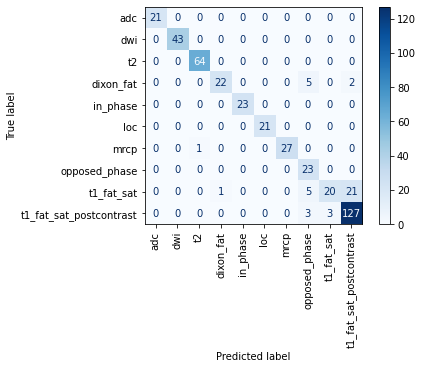

In [ ]:
display_results(results_con, key_label ='con_label_code')

In [ ]:
#MB_result_dict = display_results(results, model = model, return_values=True)

In [ ]:
#MB_result_dict

In [ ]:
#example of accessing statistic from the classification table
#round(MB_result_dict['weighted avg']['f1-score'],4)

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.94      0.77      0.85        61
       dynamic_late       0.89      1.00      0.94        17
                 t2       0.96      1.00      0.98        22
                dwi       1.00      1.00      1.00        43
                 t2       1.00      1.00      1.00        42
          dixon_fat       1.00      0.83      0.91        29
      hepatobiliary       0.00      0.00      0.00        10
      hepatobiliary       1.00      0.33      0.50         3
           in_phase       0.85      1.00      0.92        23
dynamic_equilibrium       0.50      0.50      0.50        22
                loc       1.00      1.00      1.00        21
               mrcp       1.00      0.96      0.98        28
      opposed_phase       0.64      1.00      0.78        23
      portal_venous       0.47      0.80      0.59        20
         t1_fat_sat    

,GT label,GT plane,patientID,series,SeriesDescription_y,plane,original_label_code,con_label_code,MB_label_code,textual_label_code,...,probs_2,predictions,prediction label,top label,second label,third label,DICOM_probs,GroupB_label_code,GroupC_label_code,GroupD_label_code
2,T1 fat sat,ax,102,18,ax equilibrium new,ax,16,30,25,16,...,[3.8694096e-04 4.7828564e-03 4.4627660e-03 8.6...,25,T1 fat sat,25,17,19,"[0.0, 0.0, 0.00016247796749578784, 0.000267960...",23,23,23
18,T1 fat sat,ax,102,14,ax portal venous new,ax,23,30,25,23,...,[5.5720520e-05 7.7255402e-04 5.9103292e-01 1.5...,25,T1 fat sat,25,17,19,"[0.0, 0.0, 0.00016247796749578784, 0.000267960...",2,2,2
32,T1 fat sat,ax,24,38,ax portal venous new,ax,23,30,25,23,...,[1.22124447e-05 4.93115571e-04 3.92718837e-02 ...,25,T1 fat sat,25,18,19,"[0.0, 0.0, 0.00016247796749578784, 0.000267960...",16,16,16
50,T1 fat sat,ax,15,19,ax equilibrium new,ax,16,30,25,16,...,[1.6571623e-06 2.2136648e-05 7.9564778e-03 7.0...,25,T1 fat sat,25,17,19,"[0.0, 0.0, 0.00016247796749578784, 0.000267960...",23,23,23
67,T1 fat sat,ax,46,9,WATER: ax portal venous,ax,23,30,25,23,...,[5.4942790e-05 4.8884819e-03 1.6752285e-01 5.3...,25,T1 fat sat,25,11,14,"[0.0, 0.0, 0.0005050884886598845, 0.2668984805...",12,12,12
75,T1 fat sat,ax,46,800,ax dyn,ax,25,25,25,2,...,[8.51696029e-08 1.60901309e-05 8.81324768e-01 ...,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.0024208022153789513, 0.0598063548...",2,2,2
78,T1 fat sat,ax,46,12,WATER: ax equilibrium,ax,16,30,25,16,...,[4.9229839e-06 2.9019307e-04 3.9091795e-03 6.3...,25,T1 fat sat,25,11,14,"[0.0, 0.0, 0.0005050884886598845, 0.2668984805...",23,23,23
91,T1 fat sat,ax,22,15,ax vibe triple dyn_FIL,ax,4,30,25,2,...,[8.7049502e-06 1.5381382e-04 7.8298807e-02 6.9...,25,T1 fat sat,25,19,14,"[0.0, 0.0, 0.003984618881879155, 0.00064283438...",16,16,16
98,T1 fat sat,ax,22,14,ax vibe triple dyn_FIL,ax,2,30,25,2,...,[1.53964575e-05 2.05143209e-04 3.28557372e-01 ...,25,T1 fat sat,25,19,14,"[0.0, 0.0, 0.003984618881879155, 0.00064283438...",16,16,16
101,dixon fat,ax,71,7,Dixon screen_F,ax,11,11,11,-1,...,[1.2435086e-06 2.9649233e-05 3.0571792e-07 6.9...,19,opposed phase,19,25,11,"[0.0, 0.0, 0.004697172914679811, 0.13256424834...",19,11,11


<Figure size 1800x1800 with 0 Axes>

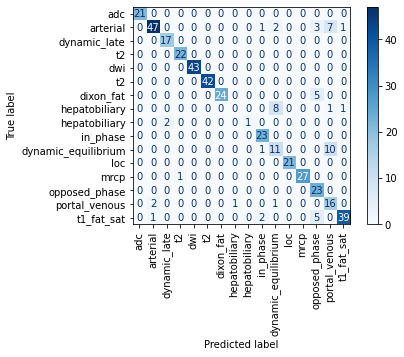

In [ ]:
display_results(results, key_label='ap_label_code', pred_col='GroupB_label_code')

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.94      0.80      0.87        61
       dynamic_late       0.89      1.00      0.94        17
                 t2       1.00      1.00      1.00        22
                dwi       1.00      1.00      1.00        43
                 t2       1.00      1.00      1.00        42
          dixon_fat       1.00      1.00      1.00        29
      hepatobiliary       0.00      0.00      0.00        10
      hepatobiliary       1.00      0.33      0.50         3
           in_phase       0.85      0.96      0.90        23
dynamic_equilibrium       0.50      0.50      0.50        22
                loc       1.00      1.00      1.00        21
               mrcp       1.00      1.00      1.00        28
      opposed_phase       0.96      1.00      0.98        23
      portal_venous       0.46      0.80      0.58        20
         t1_fat_sat    

,GT label,GT plane,patientID,series,SeriesDescription_y,plane,original_label_code,con_label_code,MB_label_code,textual_label_code,...,probs_2,predictions,prediction label,top label,second label,third label,DICOM_probs,GroupB_label_code,GroupC_label_code,GroupD_label_code
2,T1 fat sat,ax,102,18,ax equilibrium new,ax,16,30,25,16,...,[3.8694096e-04 4.7828564e-03 4.4627660e-03 8.6...,25,T1 fat sat,25,17,19,"[0.0, 0.0, 0.00016247796749578784, 0.000267960...",23,23,23
18,T1 fat sat,ax,102,14,ax portal venous new,ax,23,30,25,23,...,[5.5720520e-05 7.7255402e-04 5.9103292e-01 1.5...,25,T1 fat sat,25,17,19,"[0.0, 0.0, 0.00016247796749578784, 0.000267960...",2,2,2
32,T1 fat sat,ax,24,38,ax portal venous new,ax,23,30,25,23,...,[1.22124447e-05 4.93115571e-04 3.92718837e-02 ...,25,T1 fat sat,25,18,19,"[0.0, 0.0, 0.00016247796749578784, 0.000267960...",16,16,16
50,T1 fat sat,ax,15,19,ax equilibrium new,ax,16,30,25,16,...,[1.6571623e-06 2.2136648e-05 7.9564778e-03 7.0...,25,T1 fat sat,25,17,19,"[0.0, 0.0, 0.00016247796749578784, 0.000267960...",23,23,23
67,T1 fat sat,ax,46,9,WATER: ax portal venous,ax,23,30,25,23,...,[5.4942790e-05 4.8884819e-03 1.6752285e-01 5.3...,25,T1 fat sat,25,11,14,"[0.0, 0.0, 0.0005050884886598845, 0.2668984805...",12,12,12
72,in phase,ax,46,501,InPhase: ax lava flex,ax,14,14,14,-1,...,[3.5175897e-05 1.2537857e-03 3.8614050e-03 2.0...,14,in phase,14,25,11,"[0.0, 0.0, 0.001700733771895032, 0.13996160723...",14,19,14
75,T1 fat sat,ax,46,800,ax dyn,ax,25,25,25,2,...,[8.51696029e-08 1.60901309e-05 8.81324768e-01 ...,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.0024208022153789513, 0.0598063548...",2,2,2
78,T1 fat sat,ax,46,12,WATER: ax equilibrium,ax,16,30,25,16,...,[4.9229839e-06 2.9019307e-04 3.9091795e-03 6.3...,25,T1 fat sat,25,11,14,"[0.0, 0.0, 0.0005050884886598845, 0.2668984805...",23,23,23
91,T1 fat sat,ax,22,15,ax vibe triple dyn_FIL,ax,4,30,25,2,...,[8.7049502e-06 1.5381382e-04 7.8298807e-02 6.9...,25,T1 fat sat,25,19,14,"[0.0, 0.0, 0.003984618881879155, 0.00064283438...",16,16,16
98,T1 fat sat,ax,22,14,ax vibe triple dyn_FIL,ax,2,30,25,2,...,[1.53964575e-05 2.05143209e-04 3.28557372e-01 ...,25,T1 fat sat,25,19,14,"[0.0, 0.0, 0.003984618881879155, 0.00064283438...",16,16,16


<Figure size 1800x1800 with 0 Axes>

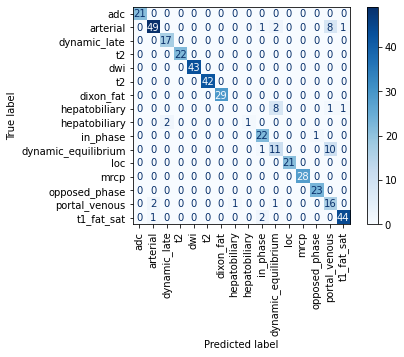

In [ ]:
#groupC
display_results(results, key_label='ap_label_code', pred_col='GroupC_label_code')

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.94      0.80      0.87        61
       dynamic_late       0.89      1.00      0.94        17
                 t2       0.96      1.00      0.98        22
                dwi       1.00      1.00      1.00        43
                 t2       1.00      1.00      1.00        42
          dixon_fat       1.00      1.00      1.00        29
      hepatobiliary       0.00      0.00      0.00        10
      hepatobiliary       1.00      0.33      0.50         3
           in_phase       0.85      1.00      0.92        23
dynamic_equilibrium       0.50      0.50      0.50        22
                loc       1.00      1.00      1.00        21
               mrcp       1.00      0.96      0.98        28
      opposed_phase       1.00      1.00      1.00        23
      portal_venous       0.46      0.80      0.58        20
         t1_fat_sat    

,GT label,GT plane,patientID,series,SeriesDescription_y,plane,original_label_code,con_label_code,MB_label_code,textual_label_code,...,probs_2,predictions,prediction label,top label,second label,third label,DICOM_probs,GroupB_label_code,GroupC_label_code,GroupD_label_code
2,T1 fat sat,ax,102,18,ax equilibrium new,ax,16,30,25,16,...,[3.8694096e-04 4.7828564e-03 4.4627660e-03 8.6...,25,T1 fat sat,25,17,19,"[0.0, 0.0, 0.00016247796749578784, 0.000267960...",23,23,23
18,T1 fat sat,ax,102,14,ax portal venous new,ax,23,30,25,23,...,[5.5720520e-05 7.7255402e-04 5.9103292e-01 1.5...,25,T1 fat sat,25,17,19,"[0.0, 0.0, 0.00016247796749578784, 0.000267960...",2,2,2
32,T1 fat sat,ax,24,38,ax portal venous new,ax,23,30,25,23,...,[1.22124447e-05 4.93115571e-04 3.92718837e-02 ...,25,T1 fat sat,25,18,19,"[0.0, 0.0, 0.00016247796749578784, 0.000267960...",16,16,16
50,T1 fat sat,ax,15,19,ax equilibrium new,ax,16,30,25,16,...,[1.6571623e-06 2.2136648e-05 7.9564778e-03 7.0...,25,T1 fat sat,25,17,19,"[0.0, 0.0, 0.00016247796749578784, 0.000267960...",23,23,23
67,T1 fat sat,ax,46,9,WATER: ax portal venous,ax,23,30,25,23,...,[5.4942790e-05 4.8884819e-03 1.6752285e-01 5.3...,25,T1 fat sat,25,11,14,"[0.0, 0.0, 0.0005050884886598845, 0.2668984805...",12,12,12
75,T1 fat sat,ax,46,800,ax dyn,ax,25,25,25,2,...,[8.51696029e-08 1.60901309e-05 8.81324768e-01 ...,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.0024208022153789513, 0.0598063548...",2,2,2
78,T1 fat sat,ax,46,12,WATER: ax equilibrium,ax,16,30,25,16,...,[4.9229839e-06 2.9019307e-04 3.9091795e-03 6.3...,25,T1 fat sat,25,11,14,"[0.0, 0.0, 0.0005050884886598845, 0.2668984805...",23,23,23
91,T1 fat sat,ax,22,15,ax vibe triple dyn_FIL,ax,4,30,25,2,...,[8.7049502e-06 1.5381382e-04 7.8298807e-02 6.9...,25,T1 fat sat,25,19,14,"[0.0, 0.0, 0.003984618881879155, 0.00064283438...",16,16,16
98,T1 fat sat,ax,22,14,ax vibe triple dyn_FIL,ax,2,30,25,2,...,[1.53964575e-05 2.05143209e-04 3.28557372e-01 ...,25,T1 fat sat,25,19,14,"[0.0, 0.0, 0.003984618881879155, 0.00064283438...",16,16,16
104,T1 fat sat,ax,71,19,ax vibe equilibrium,ax,12,30,25,16,...,[2.5617228e-05 3.3158998e-04 2.1793030e-02 1.5...,25,T1 fat sat,25,18,9,"[0.0, 0.0, 0.00040074445887629446, 0.000244618...",16,16,16


<Figure size 1800x1800 with 0 Axes>

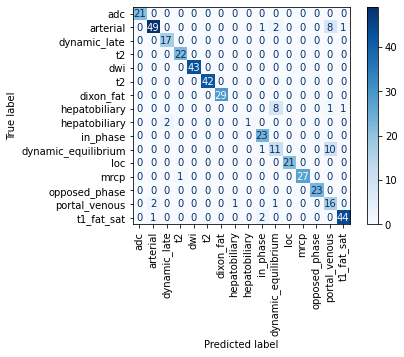

In [ ]:
#groupD
display_results(results, key_label='ap_label_code', pred_col='GroupD_label_code')

In [ ]:
###going to look at reduced number of features
feats_to_ignore = ignore_trivial_features(X_train, preproc._features, verbose=True)
feats_reduced = list(set(preproc._features)-set(feats_to_ignore))

X_train_reduced = X_train.drop(feats_to_ignore, axis=1)
X_test_reduced = X_test.drop(feats_to_ignore, axis=1)


feats to drop ['DiffusionBValue', 'seq_GR', 'seq_I', 'seq_M', 'var_MP', 'var_MTC', 'var_TOF', 'opt_1', 'opt_B', 'opt_C', 'opt_E', 'opt_FC_FREQ_AX_GEMS', 'opt_FR_GEMS', 'opt_FSA_GEMS', 'opt_FSI_GEMS', 'opt_FSL_GEMS', 'opt_FSP_GEMS', 'opt_FSS_GEMS', 'opt_G', 'opt_IFLOW_GEMS', 'opt_IR', 'opt_IR_GEMS', 'opt_L', 'opt_M', 'opt_MT', 'opt_MT_GEMS', 'opt_PROP_GEMS', 'opt_R', 'opt_RAMP_IS_GEMS', 'opt_SAT1', 'opt_T2FLAIR_GEMS', 'opt_VB_GEMS', 'opt__'] 33


In [ ]:
model_red, results_red = run_pipeline(X_train_reduced, X_test_reduced, suffix='MBreduced', features=feats_reduced)

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 2,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 323}


               precision    recall  f1-score   support

          adc       1.00      1.00      1.00        21
          dwi       1.00      1.00      1.00        43
           t2       0.98      1.00      0.99        64
    dixon_fat       1.00      0.72      0.84        29
     in_phase       1.00      1.00      1.00        23
          loc       1.00      1.00      1.00        21
         mrcp       1.00      0.96      0.98        28
opposed_phase       0.64      1.00      0.78        23
   t1_fat_sat       0.98      0.96      0.97       180

     accuracy                           0.96       432
    macro avg       0.96      0.96      0.95       432
 weighted avg       0.97      0.96      0.96       432

Incorrect predictions:


,GT label,GT plane,patientID,series,SeriesDescription_y,plane,original_label_code,con_label_code,MB_label_code,textual_label_code,...,pixel_ap_label_code,predictions,prediction label,top label,second label,third label,DICOM_probs,GroupB_label_code,GroupC_label_code,GroupD_label_code
62,dixon fat,ax,46,900,FAT: ax portal venous,ax,11,11,11,23,...,11,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.0005785673733131512, 0.3070737774...",11,11,11
64,dixon fat,ax,46,1200,FAT: ax equilibrium,ax,11,11,11,16,...,11,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.0005785673733131512, 0.3070737774...",11,11,11
73,dixon fat,ax,46,500,FAT: ax lava flex,ax,11,11,11,-1,...,11,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.001503674258172358, 0.34531695833...",11,11,11
101,dixon fat,ax,71,7,Dixon screen_F,ax,11,11,11,-1,...,11,19,opposed phase,19,25,11,"[0.0, 0.0, 0.0072577659387632575, 0.1614722571...",19,11,11
103,T1 fat sat,ax,71,6,Dixon screen_W,ax,25,25,25,-1,...,25,19,opposed phase,19,25,11,"[0.0, 0.0, 0.0072577659387632575, 0.1614722571...",19,25,25
131,dixon fat,ax,49,15,Dixon screen_F,ax,11,11,11,-1,...,11,19,opposed phase,19,25,11,"[0.0, 0.0, 0.007398492085681355, 0.14271062958...",19,11,11
135,T1 fat sat,ax,49,14,Dixon screen_W,ax,25,25,25,-1,...,25,19,opposed phase,19,25,11,"[0.0, 0.0, 0.007398492085681355, 0.14271062958...",19,25,25
222,dixon fat,ax,97,7,Dixon screen_F,ax,11,11,11,-1,...,11,19,opposed phase,19,25,11,"[0.0, 0.0, 0.0072577659387632575, 0.1614722571...",19,11,11
224,T1 fat sat,ax,97,6,Dixon screen_W,ax,25,25,25,-1,...,25,19,opposed phase,19,25,11,"[0.0, 0.0, 0.0072577659387632575, 0.1614722571...",19,25,25
322,dixon fat,ax,28,16,Dixon screen_F,ax,11,11,11,-1,...,11,19,opposed phase,19,25,11,"[0.0, 0.0, 0.007064267486750873, 0.19955576339...",19,11,11


<Figure size 1800x1800 with 0 Axes>

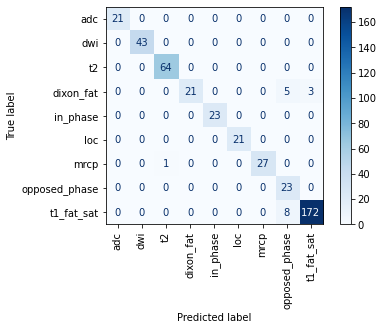

In [ ]:
display_results(results_red)

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.84      0.95      0.89        61
       dynamic_late       0.94      0.88      0.91        17
                 t2       0.96      1.00      0.98        22
                dwi       1.00      1.00      1.00        43
                 t2       1.00      1.00      1.00        42
          dixon_fat       1.00      0.83      0.91        29
      hepatobiliary       0.20      0.20      0.20        10
      hepatobiliary       1.00      0.67      0.80         3
           in_phase       0.96      1.00      0.98        23
dynamic_equilibrium       1.00      0.32      0.48        22
                loc       1.00      1.00      1.00        21
               mrcp       1.00      0.96      0.98        28
      opposed_phase       0.62      1.00      0.77        23
      portal_venous       0.55      0.60      0.57        20
         t1_fat_sat    

,GT label,GT plane,patientID,series,SeriesDescription_y,plane,original_label_code,con_label_code,MB_label_code,textual_label_code,...,pixel_ap_label_code,predictions,prediction label,top label,second label,third label,DICOM_probs,GroupB_label_code,GroupC_label_code,GroupD_label_code
2,T1 fat sat,ax,102,18,ax equilibrium new,ax,16,30,25,16,...,23,25,T1 fat sat,25,19,11,"[0.0, 0.0, 2.47864345878391e-05, 0.00276186617...",23,23,23
13,T1 fat sat,ax,102,3,ax vibe pre new,ax,25,25,25,-1,...,23,25,T1 fat sat,25,19,9,"[0.0, 0.0, 0.004760007909440045, 0.00358591363...",23,23,23
18,T1 fat sat,ax,102,14,ax portal venous new,ax,23,30,25,23,...,2,25,T1 fat sat,25,19,11,"[0.0, 0.0, 2.47864345878391e-05, 0.00276186617...",2,2,2
25,T1 fat sat,ax,24,42,ax equilibrium new,ax,16,30,25,16,...,23,25,T1 fat sat,25,19,11,"[0.0, 0.0, 2.47864345878391e-05, 0.00276186617...",23,23,23
26,T1 fat sat,ax,24,45,vibe dixon 9-14 post_W,ax,16,30,25,-1,...,12,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.0008258370068364894, 0.1087163704...",12,12,12
75,T1 fat sat,ax,46,800,ax dyn,ax,25,25,25,2,...,12,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.001073492768922856, 0.04723980226...",12,12,12
78,T1 fat sat,ax,46,12,WATER: ax equilibrium,ax,16,30,25,16,...,12,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.0005785673733131512, 0.3070737774...",12,12,12
81,T1 fat sat,ax,22,18,ax vibe equilibrium,ax,16,30,25,16,...,23,25,T1 fat sat,25,19,14,"[0.0, 0.0, 9.18687012521704e-06, 0.00036747480...",23,23,23
85,T1 fat sat,ax,22,16,ax vibe portal venous,ax,23,30,25,23,...,2,25,T1 fat sat,25,19,14,"[0.0, 0.0, 9.18687012521704e-06, 0.00036747480...",2,2,2
101,dixon fat,ax,71,7,Dixon screen_F,ax,11,11,11,-1,...,11,19,opposed phase,19,25,11,"[0.0, 0.0, 0.0072577659387632575, 0.1614722571...",19,11,11


<Figure size 1800x1800 with 0 Axes>

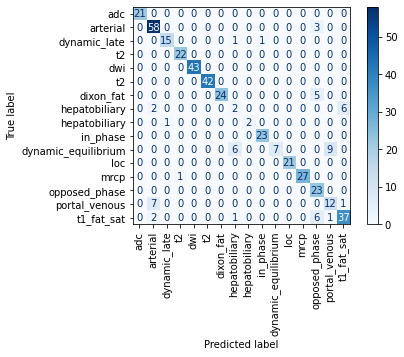

In [ ]:
#groupB reduced feature set
display_results(results_red, key_label='ap_label_code', pred_col='GroupB_label_code')

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.85      1.00      0.92        61
       dynamic_late       0.94      0.88      0.91        17
                 t2       1.00      1.00      1.00        22
                dwi       0.97      0.91      0.94        43
                 t2       0.91      1.00      0.95        42
          dixon_fat       1.00      1.00      1.00        29
      hepatobiliary       0.20      0.20      0.20        10
      hepatobiliary       1.00      0.67      0.80         3
           in_phase       0.96      1.00      0.98        23
dynamic_equilibrium       1.00      0.32      0.48        22
                loc       1.00      1.00      1.00        21
               mrcp       1.00      0.96      0.98        28
      opposed_phase       0.96      1.00      0.98        23
      portal_venous       0.55      0.60      0.57        20
         t1_fat_sat    

,GT label,GT plane,patientID,series,SeriesDescription_y,plane,original_label_code,con_label_code,MB_label_code,textual_label_code,...,pixel_ap_label_code,predictions,prediction label,top label,second label,third label,DICOM_probs,GroupB_label_code,GroupC_label_code,GroupD_label_code
2,T1 fat sat,ax,102,18,ax equilibrium new,ax,16,30,25,16,...,23,25,T1 fat sat,25,19,11,"[0.0, 0.0, 2.47864345878391e-05, 0.00276186617...",23,23,23
13,T1 fat sat,ax,102,3,ax vibe pre new,ax,25,25,25,-1,...,23,25,T1 fat sat,25,19,9,"[0.0, 0.0, 0.004760007909440045, 0.00358591363...",23,23,23
18,T1 fat sat,ax,102,14,ax portal venous new,ax,23,30,25,23,...,2,25,T1 fat sat,25,19,11,"[0.0, 0.0, 2.47864345878391e-05, 0.00276186617...",2,2,2
25,T1 fat sat,ax,24,42,ax equilibrium new,ax,16,30,25,16,...,23,25,T1 fat sat,25,19,11,"[0.0, 0.0, 2.47864345878391e-05, 0.00276186617...",23,23,23
26,T1 fat sat,ax,24,45,vibe dixon 9-14 post_W,ax,16,30,25,-1,...,12,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.0008258370068364894, 0.1087163704...",12,12,12
75,T1 fat sat,ax,46,800,ax dyn,ax,25,25,25,2,...,12,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.001073492768922856, 0.04723980226...",12,12,12
78,T1 fat sat,ax,46,12,WATER: ax equilibrium,ax,16,30,25,16,...,12,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.0005785673733131512, 0.3070737774...",12,12,12
81,T1 fat sat,ax,22,18,ax vibe equilibrium,ax,16,30,25,16,...,23,25,T1 fat sat,25,19,14,"[0.0, 0.0, 9.18687012521704e-06, 0.00036747480...",23,23,23
85,T1 fat sat,ax,22,16,ax vibe portal venous,ax,23,30,25,23,...,2,25,T1 fat sat,25,19,14,"[0.0, 0.0, 9.18687012521704e-06, 0.00036747480...",2,2,2
104,T1 fat sat,ax,71,19,ax vibe equilibrium,ax,12,30,25,16,...,25,25,T1 fat sat,25,19,14,"[0.0, 0.0, 0.00020492170360140034, 0.000367474...",25,25,25


<Figure size 1800x1800 with 0 Axes>

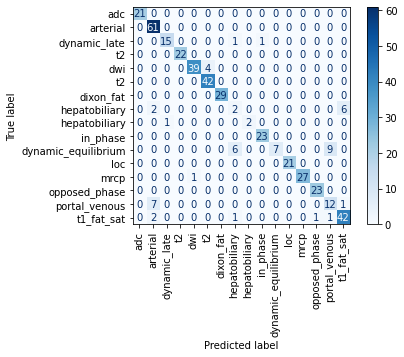

In [ ]:
#groupC reduced
display_results(results_red, key_label='ap_label_code', pred_col='GroupC_label_code')

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.85      1.00      0.92        61
       dynamic_late       0.94      0.88      0.91        17
                 t2       0.96      1.00      0.98        22
                dwi       1.00      1.00      1.00        43
                 t2       1.00      1.00      1.00        42
          dixon_fat       1.00      1.00      1.00        29
      hepatobiliary       0.20      0.20      0.20        10
      hepatobiliary       1.00      0.67      0.80         3
           in_phase       0.92      1.00      0.96        23
dynamic_equilibrium       1.00      0.32      0.48        22
                loc       1.00      1.00      1.00        21
               mrcp       1.00      0.96      0.98        28
      opposed_phase       0.96      0.96      0.96        23
      portal_venous       0.55      0.60      0.57        20
         t1_fat_sat    

,GT label,GT plane,patientID,series,SeriesDescription_y,plane,original_label_code,con_label_code,MB_label_code,textual_label_code,...,pixel_ap_label_code,predictions,prediction label,top label,second label,third label,DICOM_probs,GroupB_label_code,GroupC_label_code,GroupD_label_code
2,T1 fat sat,ax,102,18,ax equilibrium new,ax,16,30,25,16,...,23,25,T1 fat sat,25,19,11,"[0.0, 0.0, 2.47864345878391e-05, 0.00276186617...",23,23,23
13,T1 fat sat,ax,102,3,ax vibe pre new,ax,25,25,25,-1,...,23,25,T1 fat sat,25,19,9,"[0.0, 0.0, 0.004760007909440045, 0.00358591363...",23,23,23
18,T1 fat sat,ax,102,14,ax portal venous new,ax,23,30,25,23,...,2,25,T1 fat sat,25,19,11,"[0.0, 0.0, 2.47864345878391e-05, 0.00276186617...",2,2,2
25,T1 fat sat,ax,24,42,ax equilibrium new,ax,16,30,25,16,...,23,25,T1 fat sat,25,19,11,"[0.0, 0.0, 2.47864345878391e-05, 0.00276186617...",23,23,23
26,T1 fat sat,ax,24,45,vibe dixon 9-14 post_W,ax,16,30,25,-1,...,12,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.0008258370068364894, 0.1087163704...",12,12,12
75,T1 fat sat,ax,46,800,ax dyn,ax,25,25,25,2,...,12,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.001073492768922856, 0.04723980226...",12,12,12
78,T1 fat sat,ax,46,12,WATER: ax equilibrium,ax,16,30,25,16,...,12,25,T1 fat sat,25,11,19,"[0.0, 0.0, 0.0005785673733131512, 0.3070737774...",12,12,12
81,T1 fat sat,ax,22,18,ax vibe equilibrium,ax,16,30,25,16,...,23,25,T1 fat sat,25,19,14,"[0.0, 0.0, 9.18687012521704e-06, 0.00036747480...",23,23,23
85,T1 fat sat,ax,22,16,ax vibe portal venous,ax,23,30,25,23,...,2,25,T1 fat sat,25,19,14,"[0.0, 0.0, 9.18687012521704e-06, 0.00036747480...",2,2,2
104,T1 fat sat,ax,71,19,ax vibe equilibrium,ax,12,30,25,16,...,25,25,T1 fat sat,25,19,14,"[0.0, 0.0, 0.00020492170360140034, 0.000367474...",25,25,25


<Figure size 1800x1800 with 0 Axes>

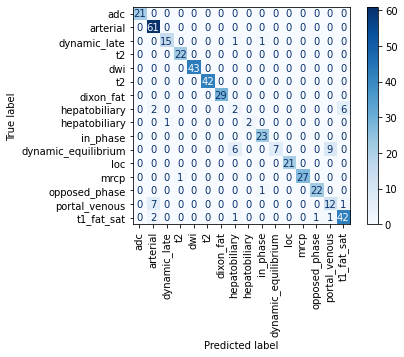

In [ ]:
#groupD reduced
display_results(results_red, key_label='ap_label_code', pred_col='GroupD_label_code')

In [ ]:
print(classification_report(results['textual_label_code'].astype(int), results['original_label_code'].astype(int)))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        93
           0       0.00      0.00      0.00         0
           2       0.97      0.60      0.75        63
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       1.00      0.68      0.81        63
           9       1.00      0.66      0.79        64
          11       0.59      1.00      0.74        17
          12       0.60      0.55      0.57        11
          13       0.00      0.00      0.00         0
          14       0.74      1.00      0.85        17
          16       0.82      0.67      0.73        27
          17       1.00      1.00      1.00        21
          18       0.00      0.00      0.00         0
          19       0.74      1.00      0.85        17
          23       1.00    

/Users/cmm/opt/anaconda3/envs/MRI_project2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cmm/opt/anaconda3/envs/MRI_project2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cmm/opt/anaconda3/envs/MRI_project2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

In [ ]:
print(classification_report(results['pixel_ap_label_code'].astype(int), results['ap_label_code'].astype(int)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       1.00      0.82      0.90        74
           6       0.88      0.94      0.91        16
           7       0.82      0.90      0.86        20
           8       0.58      0.86      0.69        29
           9       0.88      0.63      0.73        59
          11       1.00      0.94      0.97        31
          12       0.20      0.20      0.20        10
          13       0.67      1.00      0.80         2
          14       1.00      0.92      0.96        25
          15       0.00      0.00      0.00         2
          16       0.32      1.00      0.48         7
          17       0.86      0.90      0.88        20
          18       0.75      1.00      0.86        21
          19       0.96      0.96      0.96        23
          23       0.60      0.55      0.57        22
          25       0.89      0.84      0.87        50

    accuracy              

/Users/cmm/opt/anaconda3/envs/MRI_project2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cmm/opt/anaconda3/envs/MRI_project2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cmm/opt/anaconda3/envs/MRI_project2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [ ]:
def boostrap_results(model, Xtest, truth_label, pred_label, features = preproc._features, sample_fraction = 0.5, num_iter = 1000):
    num_labels = 35
    results_array = np.zeros((num_iter, num_labels, 10))
    samples = Xtest.copy()
    rng = np.random.RandomState(seed=0)
    idx_list = np.arange(samples.shape[0])
    accuracy_list = []
    f1_score_list = []
    
    #print(results_array)
    for i in range(num_iter):
        
        
        idx = rng.choice(idx_list, size=int(sample_fraction*len(idx_list)), replace=True)
        #print(idx)
        
        _, results =run_pipeline(None, Xtest.iloc[idx], opt_model=model, trained=True, truth_label=truth_label, features=features)

        result_dict = display_results(results, key_label = truth_label, pred_col = pred_label, return_values=True, verbose=False)
        #def display_results(resultsdf, model=None, data = None, key_label = 'MB_label_code', pred_col = 'predictions', return_values=False):
        #print(result_dict['accuracy'])
        acc = result_dict.get('accuracy', None)
        f1 = result_dict['weighted avg'].get('f1-score', None)
        if ((acc==None)|(f1==None)):
            print(i, result_dict)
        else: 
            accuracy_list.append(acc)
            f1_score_list.append(f1)
    #print(accuracy_list, f1_score_list)
                             
    return accuracy_list, f1_score_list
    
    

In [ ]:
acc_list, f1_list = boostrap_results(model, X_test, 'MB_label_code','predictions', sample_fraction = 0.5, num_iter = 1000) 

In [ ]:
acc_list_red, f1_list_red = boostrap_results(model_red, X_test_reduced, 'MB_label_code','predictions', feats_reduced, 0.5, 1000) 

In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
acc_list_B, f1_list_B = boostrap_results(model, X_test, 'ap_label_code','GroupB_label_code', sample_fraction = 0.5, num_iter = 1000) 

226 {'adc': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 19}, 'arterial': {'precision': 0.84, 'recall': 0.9130434782608695, 'f1-score': 0.8749999999999999, 'support': 23}, 'dynamic_late': {'precision': 0.9285714285714286, 'recall': 0.8666666666666667, 'f1-score': 0.896551724137931, 'support': 15}, 't2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21}, 'dwi': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21}, 'dixon_fat': {'precision': 1.0, 'recall': 0.9130434782608695, 'f1-score': 0.9545454545454545, 'support': 23}, 'hepatobiliary': {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 4}, 'in_phase': {'precision': 0.875, 'recall': 1.0, 'f1-score': 0.9333333333333333, 'support': 14}, 'dynamic_equilibrium': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}, 'loc': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'mrcp': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support':

In [ ]:
acc_list_red_B, f1_list_red_B = boostrap_results(model_red, X_test_reduced, 'ap_label_code', 'GroupB_label_code', feats_reduced, 0.5, 1000) 

226 {'adc': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 19}, 'arterial': {'precision': 0.84, 'recall': 0.9130434782608695, 'f1-score': 0.8749999999999999, 'support': 23}, 'dynamic_late': {'precision': 0.9285714285714286, 'recall': 0.8666666666666667, 'f1-score': 0.896551724137931, 'support': 15}, 't2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21}, 'dwi': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21}, 'dixon_fat': {'precision': 1.0, 'recall': 0.9130434782608695, 'f1-score': 0.9545454545454545, 'support': 23}, 'hepatobiliary': {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 4}, 'in_phase': {'precision': 0.875, 'recall': 1.0, 'f1-score': 0.9333333333333333, 'support': 14}, 'dynamic_equilibrium': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}, 'loc': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'mrcp': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support':

In [ ]:
acc_list_C, f1_list_C = boostrap_results(model, X_test, 'ap_label_code','GroupC_label_code', sample_fraction = 0.5, num_iter = 1000) 

226 {'adc': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 19}, 'arterial': {'precision': 0.8518518518518519, 'recall': 1.0, 'f1-score': 0.92, 'support': 23}, 'dynamic_late': {'precision': 0.9285714285714286, 'recall': 0.8666666666666667, 'f1-score': 0.896551724137931, 'support': 15}, 't2': {'precision': 0.9545454545454546, 'recall': 1.0, 'f1-score': 0.9767441860465117, 'support': 21}, 'dwi': {'precision': 1.0, 'recall': 0.9523809523809523, 'f1-score': 0.975609756097561, 'support': 21}, 'dixon_fat': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23}, 'hepatobiliary': {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 4}, 'in_phase': {'precision': 0.875, 'recall': 1.0, 'f1-score': 0.9333333333333333, 'support': 14}, 'dynamic_equilibrium': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}, 'loc': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'mrcp': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1

In [ ]:
acc_list_red_C, f1_list_red_C = boostrap_results(model_red, X_test_reduced, 'ap_label_code', 'GroupC_label_code', feats_reduced, 0.5, 1000) 

226 {'adc': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 19}, 'arterial': {'precision': 0.8518518518518519, 'recall': 1.0, 'f1-score': 0.92, 'support': 23}, 'dynamic_late': {'precision': 0.9285714285714286, 'recall': 0.8666666666666667, 'f1-score': 0.896551724137931, 'support': 15}, 't2': {'precision': 0.9130434782608695, 'recall': 1.0, 'f1-score': 0.9545454545454545, 'support': 21}, 'dwi': {'precision': 1.0, 'recall': 0.9047619047619048, 'f1-score': 0.9500000000000001, 'support': 21}, 'dixon_fat': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23}, 'hepatobiliary': {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 4}, 'in_phase': {'precision': 0.875, 'recall': 1.0, 'f1-score': 0.9333333333333333, 'support': 14}, 'dynamic_equilibrium': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}, 'loc': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'mrcp': {'precision': 1.0, 'recall': 1.0, 'f1-score': 

In [ ]:
acc_list_D, f1_list_D = boostrap_results(model, X_test, 'ap_label_code','GroupD_label_code', sample_fraction = 0.5, num_iter = 1000) 

226 {'adc': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 19}, 'arterial': {'precision': 0.8518518518518519, 'recall': 1.0, 'f1-score': 0.92, 'support': 23}, 'dynamic_late': {'precision': 0.9285714285714286, 'recall': 0.8666666666666667, 'f1-score': 0.896551724137931, 'support': 15}, 't2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21}, 'dwi': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21}, 'dixon_fat': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23}, 'hepatobiliary': {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 4}, 'in_phase': {'precision': 0.875, 'recall': 1.0, 'f1-score': 0.9333333333333333, 'support': 14}, 'dynamic_equilibrium': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}, 'loc': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'mrcp': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12}, 'opposed_phase': {'precision': 1.0, 're

In [ ]:
acc_list_red_D, f1_list_red_D = boostrap_results(model_red, X_test_reduced, 'ap_label_code', 'GroupD_label_code', feats_reduced, 0.5, 1000) 

226 {'adc': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 19}, 'arterial': {'precision': 0.8518518518518519, 'recall': 1.0, 'f1-score': 0.92, 'support': 23}, 'dynamic_late': {'precision': 0.9285714285714286, 'recall': 0.8666666666666667, 'f1-score': 0.896551724137931, 'support': 15}, 't2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21}, 'dwi': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21}, 'dixon_fat': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23}, 'hepatobiliary': {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 4}, 'in_phase': {'precision': 0.875, 'recall': 1.0, 'f1-score': 0.9333333333333333, 'support': 14}, 'dynamic_equilibrium': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}, 'loc': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'mrcp': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12}, 'opposed_phase': {'precision': 1.0, 're

In [ ]:
#to print stats around bootstrapping test preds--for mb
boot_df = pd.DataFrame({'accuracy':acc_list, 'f1_score': f1_list, 'accuracy_red':acc_list_red, 'f1_score_red':f1_list_red})
boot_df2 = pd.DataFrame({'accuracy_B':acc_list_B, 'f1_score_B':f1_list_B, 'accuracy_B_red':acc_list_red_B, 'f1_score_B_red': f1_list_red_B, 'accuracy_C': acc_list_C, 'f1_score_C' : f1_list_C, 'accuracy_red_C': acc_list_red_C, 'f1_score_red_C': f1_list_red_C, 'accuracy_D': acc_list_D, 'f1_score_D': f1_list_D, 'accuracy_red_D': acc_list_red_D, 'f1_score_red_D': f1_list_red_D})
boot_df.describe()

,accuracy,f1_score,accuracy_red,f1_score_red
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.960412,0.962252,0.960412,0.962252
std,0.012787,0.011913,0.012787,0.011913
min,0.912037,0.919064,0.912037,0.919064
25%,0.953704,0.954610,0.953704,0.954610
50%,0.962963,0.962896,0.962963,0.962896
75%,0.967593,0.970737,0.967593,0.970737
max,0.995370,0.995426,0.995370,0.995426


In [ ]:
boot_df2.describe()

,accuracy_B,f1_score_B,accuracy_B_red,f1_score_B_red,accuracy_C,f1_score_C,accuracy_red_C,f1_score_red_C,accuracy_D,f1_score_D,accuracy_red_D,f1_score_red_D
count,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000
mean,0.877093,0.871389,0.877093,0.871389,0.900932,0.892854,0.898666,0.890580,0.904843,0.896848,0.904843,0.896848
std,0.022314,0.023890,0.022314,0.023890,0.020290,0.022709,0.020457,0.022858,0.019925,0.022353,0.019925,0.022353
min,0.800926,0.792296,0.800926,0.792296,0.833333,0.818907,0.828704,0.814157,0.833333,0.825178,0.833333,0.825178
25%,0.861111,0.855165,0.861111,0.855165,0.888889,0.878880,0.884259,0.876121,0.888889,0.881923,0.888889,0.881923
50%,0.875000,0.871805,0.875000,0.871805,0.902778,0.893790,0.898148,0.891188,0.907407,0.898301,0.907407,0.898301
75%,0.893519,0.888859,0.893519,0.888859,0.916667,0.908814,0.912037,0.906251,0.921296,0.913087,0.921296,0.913087
max,0.935185,0.936754,0.935185,0.936754,0.953704,0.952789,0.953704,0.952789,0.958333,0.958796,0.958333,0.958796


In [ ]:
####add ap_label_code to the train and test datasets
#X_train['ap_label_code'] = X_train['original_label_code']
#X_train['ap_label_code'] = X_train['ap_label_code'].apply(lambda x: 2 if x in [3,4] else x)

X_test['ap_label_code'] = X_test['original_label_code']
X_test['ap_label_code'] = X_test['ap_label_code'].apply(lambda x: 2 if x in [3,4] else x)

X_test.head()

,fname_x,StudyInstanceUID,SeriesInstanceUID,SeriesNumber,SeriesDescription_x,AcquisitionNumber,InstanceNumber,ImageOrientationPatient,MRAcquisitionType,AngioFlag,...,GT label,GT plane,GT contrast,original_label_code,con_label_code,MB_label_code,prob_avg,pixel_label_code,textual_label_code,ap_label_code
0,Abdominal MRI data/102/exam1/16 (1-40)/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.0428166884534776243534...,16,ax diff_TRACEW,1.0,10,"[1, 0, 0, 0, 1, 0]",0,1,...,dwi,ax,0,8,8,8,"[3.1284948e-05, 1.6915199e-05, 0.0001322235, 1...",9,8,8
1,Abdominal MRI data/102/exam1/16 (41-80)/0073.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.0428166884534776243534...,16,ax diff_TRACEW,1.0,73,"[1, 0, 0, 0, 1, 0]",0,1,...,dwi,ax,0,8,8,8,"[1.1402206e-05, 3.274956e-08, 6.8182663e-07, 2...",9,8,8
2,Abdominal MRI data/102/exam1/18/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.3046323768673003518430...,18,ax equilibrium new,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,dynamic_equilibrium,ax,1,16,30,25,"[7.485561e-08, 6.9257175e-07, 0.07679371, 0.00...",23,16,16
3,Abdominal MRI data/102/exam1/11/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.2688855248684316807267...,11,ax dyn new,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,early_arterial,ax,1,3,30,25,"[1.7049644e-10, 1.5578018e-09, 0.6867239, 0.31...",2,2,2
4,Abdominal MRI data/102/exam1/7/0010.dcm,3.6.6.0.1.5.25014.2.1.1.5045676706471048775883...,3.2.5.8.6.0.77242.2.1.1.5152335108081034426775...,7,ax dixon_W,1.0,10,"[1, 0, 0, 0, 1, 0]",1,1,...,t1_fat_sat,ax,0,25,25,25,"[1.2793084e-09, 5.4996406e-08, 4.0720603e-05, ...",25,25,25


In [ ]:
import warnings
warnings.filterwarnings("ignore")

acc_list_B, f1_list_B = boostrap_results(model, X_test,'ap_label_code','GroupB_label_code', sample_fraction = 0.5, num_iter  =1000) 
boot_df_B = pd.DataFrame({'accuracy':acc_list_B, 'f1_score': f1_list_B})
boot_df_B.describe()

226 {'adc': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 19}, 'arterial': {'precision': 0.84, 'recall': 0.9130434782608695, 'f1-score': 0.8749999999999999, 'support': 23}, 'dynamic_late': {'precision': 0.9285714285714286, 'recall': 0.8666666666666667, 'f1-score': 0.896551724137931, 'support': 15}, 't2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21}, 'dwi': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21}, 'dixon_fat': {'precision': 1.0, 'recall': 0.9130434782608695, 'f1-score': 0.9545454545454545, 'support': 23}, 'hepatobiliary': {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 4}, 'in_phase': {'precision': 0.875, 'recall': 1.0, 'f1-score': 0.9333333333333333, 'support': 14}, 'dynamic_equilibrium': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}, 'loc': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'mrcp': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support':

,accuracy,f1_score
count,993.000000,993.000000
mean,0.877093,0.871389
std,0.022314,0.023890
min,0.800926,0.792296
25%,0.861111,0.855165
50%,0.875000,0.871805
75%,0.893519,0.888859
max,0.935185,0.936754


In [ ]:
len(acc_list_red_C), len(f1_list_red_C)

(993, 993)

In [ ]:
### perform one way anova between groups B-D
from scipy.stats import f_oneway, ttest_ind

In [ ]:
f_oneway(acc_list_B, acc_list_C, acc_list_D)

F_onewayResult(statistic=514.360506983251, pvalue=1.3748724202328663e-192)

In [ ]:
f_oneway(acc_list_red_B, acc_list_red_C, acc_list_red_D)

F_onewayResult(statistic=481.44464395414747, pvalue=7.07325580781396e-182)

In [ ]:
f_oneway(f1_list_B, f1_list_C,f1_list_D) 

F_onewayResult(statistic=352.1127727905787, pvalue=5.554373136096614e-138)

In [ ]:
f_oneway(f1_list_red_B, f1_list_red_C,f1_list_red_D) 

F_onewayResult(statistic=329.0774711601599, pvalue=7.682050757292217e-130)

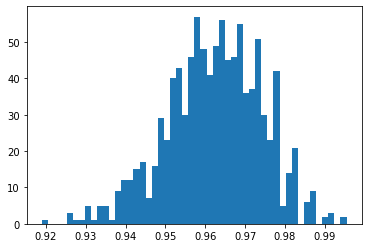

In [ ]:
plt.hist(f1_list, bins=50)
plt.show()

In [ ]:
feats_to_ignore

['DiffusionBValue',
 'seq_GR',
 'seq_I',
 'seq_M',
 'var_MP',
 'var_MTC',
 'var_TOF',
 'opt_1',
 'opt_B',
 'opt_C',
 'opt_E',
 'opt_FC_FREQ_AX_GEMS',
 'opt_FR_GEMS',
 'opt_FSA_GEMS',
 'opt_FSI_GEMS',
 'opt_FSL_GEMS',
 'opt_FSP_GEMS',
 'opt_FSS_GEMS',
 'opt_G',
 'opt_IFLOW_GEMS',
 'opt_IR',
 'opt_IR_GEMS',
 'opt_L',
 'opt_M',
 'opt_MT',
 'opt_MT_GEMS',
 'opt_PROP_GEMS',
 'opt_R',
 'opt_RAMP_IS_GEMS',
 'opt_SAT1',
 'opt_T2FLAIR_GEMS',
 'opt_VB_GEMS',
 'opt__']

In [ ]:
##ignore after this###


In [ ]:
#this is the original labels trying to predict without pooling
#display_results(orig_model, X_test, orig_results, 'original_label_code')

In [ ]:
model_con, results_con = run_pipeline(X_train, X_test, key_label='con_label_code', suffix='con')

In [ ]:
display_results(model_con, X_test, results_con, 'con_label_code')

In [ ]:
worst = X_train[X_train.original_label_code.apply(lambda x: x in [11,19,25, 16])]
worst_trimmed = worst[preproc._features+['original_label_code','SeriesDescription_x', 'patientID']]

In [ ]:
worst_trimmed[worst_trimmed.SeriesDescription_x.str.contains('portal')]

In [ ]:
# GET THE DICOM DATAFRAME - FIRST DCM = TRUE

#dicom_tuple = get_dicoms(data_path, first_dcm = True)
#dicom_paths, df_dicom = dicom_tuple

#df_dicom.T


In [ ]:
#working_df_processed=preprocess(working_df)
#working_df_prepared = prepare_dataframe(working_df, labels_file_path, labelmap = abd_label_dict_updated, filenamecols = filename_columns)

#dev_df_prepared = prepare_dataframe(dev_df, labels_file_path, labelmap = abd_label_dict_updated, filenamecols = filename_columns)
#test_df_prepared = prepare_dataframe(test_df, labels_file_path, labelmap = abd_label_dict_updated, filenamecols = filename_columns)


In [ ]:
train_df, validation, y, y_names = train_setup_abdomen(dev_df_prepared)


In [ ]:
y_names

In [ ]:
validation_base = validation[['SeriesDescription_y', 'plane','seq_label','contrast','label_code', 'patientID', 'series']]
validation_base
## this is for use later when bring in image data

In [ ]:
#train_df['type_ADC'][:30]

In [ ]:
# list unique patientID in the train set
train_ID_list = patientID_list(train_df)
train_ID_list, len(train_ID_list)


In [ ]:
# list unique patientID in the validation set

val_ID_list = patientID_list(validation)
val_ID_list, len(val_ID_list)

In [ ]:
test_ID_list = patientID_list(test_df)
test_ID_list, len(test_ID_list)


In [ ]:
validation

In [ ]:

print_label_list(preproc.abd_label_dict)

In [ ]:
print_label_list(preproc.abd_label_dict_updated)

In [ ]:
#look at number of each y value
label_value_counts(train_df)

In [ ]:
#look at number of each y value
label_value_counts(validation)


In [ ]:
label_value_counts(test_df_prepared)

In [ ]:
#create second dataframe with all post contrast series coalesced into 30 (ax) and 31 (cor)


train_contrast = merge_contrasted_series(train_df)

validation_contrast = merge_contrasted_series(validation)

test_contrast = merge_contrasted_series(test_df_prepared)

#validation_contrast

In [ ]:


label_value_counts(validation_contrast)   


In [ ]:
#train_unknown=train_df.loc[(train_df['GT label']=='unknown')]
#validation_unknown=validation_contrast.loc[validation_contrast['label_code']==1]
#train_unknown

In [ ]:
##exclude low numbers, merge cor and ax post con, and research cases ***
test_contrast_exclude = exclude_cases_and_merge(test_contrast, [21,22,26], [(31,30), (24,25)], premerged_label_code='contrast_merged_label_code')
train_contrast_exclude = exclude_cases_and_merge(train_contrast, [1, 22, 26, 21, 29], [(31,30),(20,19), (15,14), (28, 7), (10,8)])
validation_contrast_exclude = exclude_cases_and_merge(validation_contrast, [], [(31,30)])


test_MB = exclude_cases_and_merge(test_contrast_exclude, [], [(7,9),(30,25)], premerged_label_code = 'con_plane_label_code')
train_MB = exclude_cases_and_merge(train_contrast_exclude, [], [(7,9),(30,25)], premerged_label_code='con_plane_label_code')
val_MB = exclude_cases_and_merge(validation_contrast_exclude, [], [(7,9), (30,25)], premerged_label_code='con_plane_label_code')


In [ ]:
len(test_MB)+len(train_MB)+len(val_MB)

In [ ]:
len(train_df)/2215

In [ ]:
#val_MB.loc[(val_MB['label_code']==25)]

In [ ]:
val_MB

In [ ]:
##new for paper

## feature set
train_contrast_exclude.info()


In [ ]:
y_ce, y_names_ce = train_contrast_exclude['label_code'],train_contrast_exclude['GT label']



In [ ]:
my_clf_contrast_exclude=train_fit(train_contrast_exclude,y_ce, features=preproc._features, fname='baseline_model2022_12_01.skl')
my_clf_contrast_exclude

In [ ]:

predictions = my_clf_contrast_exclude.predict(validation_contrast_exclude[preproc._features])
predictions

In [ ]:
prediction_df=compare_prediction_df(validation_contrast_exclude, predictions,['GT label', 'patientID', 'series', 'original_label_code'])

prediction_df

In [ ]:
prediction_incorrect=prediction_df.loc[(prediction_df['label_code']!=prediction_df['predictions'])]
prediction_correct=prediction_df.loc[(prediction_df['label_code']==prediction_df['predictions'])]
prediction_incorrect

In [ ]:
prediction_accuracy_by_code(prediction_df, 11)

In [ ]:
prediction_incorrect1 = prediction_incorrect.loc[(prediction_incorrect['predictions']==1)]
prediction_correct1=prediction_correct.loc[(prediction_correct['predictions']==1)]
prediction_incorrect1


In [ ]:
prediction_accuracy_by_code(prediction_df,1)

In [ ]:
prediction_table(prediction_df, range(32))

In [ ]:
len(validation_contrast_exclude['label_code'])
plot_confusion_matrix(my_clf_contrast_exclude, validation_contrast_exclude[preproc._features], validation_contrast_exclude['label_code'])  

In [ ]:
print(classification_report(prediction_df['label_code'], prediction_df['predictions']))


In [ ]:
my_clf_contrast_exclude.get_params(deep = True)

In [ ]:
my_clf_contrast_exclude.feature_importances_

In [ ]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(my_clf_contrast_exclude.estimators_[0], 
          feature_names=validation_contrast_exclude[preproc._features].columns,
          class_names = str(my_clf_contrast_exclude.classes_),
          filled=True, impurity=True, 
          rounded=True)



In [ ]:
feat_importance2 = my_clf_contrast_exclude.feature_importances_
feat_importance_list2 = list(zip(feat_importance2, preproc._features))
feat_importance_list2

sorted_list2 = sorted(feat_importance_list2, key = lambda x: x[0], reverse=True)
#sorted_feat_importance_list=feat_importance_list.sort(key=lambda x: x[0], reverse=True)
#sorted_feat_importance_list
sorted_list2

In [ ]:
#pd.set_option('display.max_rows', 400)
#pd.set_option('display.max_columns', 400)

In [ ]:
#train_contrast['label_code'].value_counts()

In [ ]:
#validation_contrast['label_code'].value_counts()

In [ ]:
#other iterations to get rid of the y avlues with low numbers, also created for the set where post contrast labels are collapsed into single post con ax and post con cor

#low_y_values=[1,5,10,15,20,28]
#train_rid_low_y_values = train_df.loc[~train_df['label_code'].isin(low_y_values)]#

#train_contrast_ridlowy = train_contrast.loc[~train_contrast['label_code'].isin(low_y_values)]
#train_contrast_ridlowy

#y_rid, y_rid_names = train_rid_low_y_values['label_code'],train_rid_low_y_values['GT label']
#y_rid_contrast, y_rid_contrast_names = train_contrast_ridlowy['label_code'], train_contrast_ridlowy['GT label']



In [ ]:
#y_ce.loc[y_ce==31]

In [ ]:
my_clf_trial_ce_alt = train_fit_parameter_trial(train_contrast_exclude, y_ce, features=preproc._features, fname='trial_ce_2022_12_01a.skl')


In [ ]:
fig2 = plt.figure(figsize=(15, 10))
plot_tree(my_clf_trial_ce_alt.best_estimator_[0], 
          feature_names=validation_contrast_exclude[preproc._features].columns,
          class_names = str(my_clf_trial_ce_alt.classes_),
          filled=True, impurity=True, 
          rounded=True)






In [ ]:
#my_clf_trial=train_fit_parametertrial(train_df,y, features=preproc._features, fname='trial_whole_set0608redunk.skl')
#my_clf_trial_con_ridlowy = train_fit_parametertrial(train_contrast_ridlowy, y_rid_contrast, features=preproc._features, fname='trial_con_ridlowy0608redunk')



In [ ]:
prediction_trial_ce = my_clf_trial_ce_alt.predict(validation_contrast_exclude[preproc._features])
#prediction_trial_ce_alt = my_clf_trial_ce_alt.predict(validation_contrast_exclude[preproc._features])

prediction_df_trial_ce=compare_prediction_df(validation_contrast_exclude, prediction_trial_ce, ['GT label', 'patientID', 'series', 'original_label_code'])
#prediction_df_trial_ce_alt=compare_prediction_df(validation_contrast_exclude, prediction_trial_ce_alt, ['GT label', 'patientID', 'series'])


prediction_df_trial_ce
#prediction_df_trial_ce_alt

prediction_trial_incorrect=prediction_df_trial_ce.loc[(prediction_df_trial_ce['label_code']!=prediction_df_trial_ce['predictions'])]

prediction_trial_correct=prediction_df_trial_ce.loc[(prediction_df_trial_ce['label_code']==prediction_df_trial_ce['predictions'])]

prediction_trial_incorrect


In [ ]:
prediction_table(prediction_df_trial_ce, range(32))


In [ ]:
prediction_table(prediction_df_trial_ce, range(32))

In [ ]:
print(classification_report(prediction_df_trial_ce['label_code'], prediction_df_trial_ce['predictions']))


In [ ]:
print(classification_report(prediction_df_trial_ce['label_code'], prediction_df_trial_ce['predictions']))



In [ ]:
len(validation_contrast['label_code'])
plot_confusion_matrix(my_clf_trial_ce_alt, validation_contrast_exclude[preproc._features], validation_contrast_exclude['label_code']) 

In [ ]:
#gss = GroupShuffleSplit(n_splits=2, train_size=.8, random_state=42)

#train_gss, validation_gss = next(GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 42).split(train_df_plus_labels, groups=train_df_plus_labels['patientID']))

#train_opt=train_df_plus_labels.iloc[train_gss]
#validation_opt = train_df_plus_labels.iloc[validation_gss]
#y_opt, y_names_opt = train_opt['label_code'],train_opt['GT label']


In [ ]:
#print(classification_report(prediction_con_ridlowy_df['label_code'], prediction_con_ridlowy_df['predictions']))


In [ ]:
#feat_importance = my_clf_trial.feature_importances_
feat_importance = my_clf_trial_ce_alt.estimator.feature_importances_
feat_importance_list = list(zip(feat_importance, preproc._features))
feat_importance_list

sorted_list = sorted(feat_importance_list, key = lambda x: x[0], reverse=True)
#sorted_feat_importance_list=feat_importance_list.sort(key=lambda x: x[0], reverse=True)
#sorted_feat_importance_list
sorted_list


In [ ]:
my_clf_trial_ce_alt.best_params_


In [ ]:
#feat_importance for the contrast collapsed rid low y set:

#feat_importance_cr = my_clf_trial_con_ridlowy.estimator.feature_importances_
#feat_importance_list_cr = list(zip(feat_importance_cr, preproc._features))
#feat_importance_list_cr

#sorted_list_cr = sorted(feat_importance_list_cr, key = lambda x: x[0], reverse=True)
#sorted_feat_importance_list=feat_importance_list.sort(key=lambda x: x[0], reverse=True)
#sorted_feat_importance_list
#sorted_list_cr



In [ ]:
#my_clf_trial_con_ridlowy.best_params_

In [ ]:
prediction_validation_check = create_probs_and_top3(my_clf_trial_ce_alt, validation_contrast_exclude, prediction_df_trial_ce)
prediction_validation_check

In [ ]:
prediction_validation_check_incorrect = prediction_validation_check.loc[(prediction_validation_check['predictions']!=prediction_validation_check['label_code'])]
prediction_validation_check_incorrect

In [ ]:
prediction_validation_check_correct = prediction_validation_check.loc[(prediction_validation_check['predictions']==prediction_validation_check['label_code'])]
prediction_validation_check_correct

In [ ]:
#prediction_ce.loc[prediction_ce['label_code']==11]

In [ ]:
#of the validation predictions that are correct, the ones where the prob is less than 0.7
prediction_validation_not_confident = prediction_validation_check_correct.loc[(prediction_validation_check_correct['probability']<0.7)]
prediction_validation_not_confident
##there are 22 of these

In [ ]:
len(validation_contrast_exclude['label_code'])
plot_confusion_matrix(my_clf_trial_ce_alt, validation_contrast_exclude[preproc._features], validation_contrast_exclude['label_code'])  

In [ ]:
#def get_dummies_for_adc(df, cols=['ImageType'], prefix='type'):
#    df1 = df.copy()
#    for i, col in enumerate(cols):
#        print(i,col)
#        df1[col] = df1[col].fillna('NONE')
#        mlb = MultiLabelBinarizer()
#        df1 = df1.join(
#            pd.DataFrame(mlb.fit_transform(df1.pop(col)), columns=mlb.classes_).add_prefix(f'{prefix[i]}_')
#        )
#    return df1



In [ ]:
#from sklearn.preprocessing import MultiLabelBinarizer
#train_WW_plus_labels['ImageType']="None"
#adc_df = get_dummies_for_adc(train_WW_plus_labels)


In [ ]:

# Save to file in the current working directory
pkl_filename = "pickle_model_contrast_exclude12012022.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(my_clf_trial_ce_alt, file)

# Load from file
#with open(pkl_filename, 'rb') as file:
#    pickle_model = pickle.load(file)
    

In [ ]:
with open(pkl_filename, 'rb') as file:
    new_pickled_model = pickle.load(file)
    

In [ ]:
plot_confusion_matrix(new_pickled_model, validation_contrast_exclude[preproc._features], validation_contrast_exclude['label_code'])  

In [ ]:
new_pickled_model.best_params_


In [ ]:
#optimized parameters from last:
#n_estimators=1340
#min_samples_split=10
#min_samples_leaf=1
#max_features='auto'
#max_depth=660
#bootstrap=False

#optimized parametsr from 12/2/2022
n_estimators=222
min_samples_split=10
min_samples_leaf=2
max_features='sqrt'
max_depth=None
bootstrap=False




In [ ]:
#validation_contrast_exclude

In [ ]:
validation_contrast_exclude['label_code'].value_counts()

In [ ]:
#train entire development set with optimal parameters

##next several cells not run on latest training as kept the model from the training dataset rather than making one for the develop dataset

#development_df= pd.concat([train_contrast_ridlowy, validation_contrast])
#development_df

In [ ]:
#development_df['label_code'].value_counts()

In [ ]:
#development_df.to_pickle('MRI_abd_development0506b.pkl')

In [ ]:
#my_model=RandomForestClassifier(n_jobs=2, 
#    n_estimators=n_estimators,
#    min_samples_split=min_samples_split,
#    min_samples_leaf=min_samples_leaf,
#    max_features=max_features,
#    max_depth=max_depth,
#    bootstrap=bootstrap)

#clf_development=my_model.fit(development_df[preproc._features], development_df['label_code'])


In [ ]:
#clf_development
# Save to file in the current working directory
#pkl_filename = "pickle_model_dev0506b.pkl"
#with open(pkl_filename, 'wb') as file:
#    pickle.dump(clf_development, file)




In [ ]:
#new_predictions_on_val=clf_development.predict(validation_contrast[preproc._features])
#new_predictions_on_val

In [ ]:
#plot_confusion_matrix(clf_development, validation_contrast[preproc._features], validation_contrast['label_code'])  

In [ ]:
#prepare test dataset for predictions

#test_df=pd.read_pickle('MRI_abd_test.pkl')

In [ ]:
test_contrast_exclude

In [ ]:
#training data where labeld as 25 but could be post con
train_contrast_exclude.loc[(train_contrast_exclude['ContrastBolusAgent']==1)].loc[(train_contrast_exclude['label_code']==25)]

In [ ]:
#training data where label says post con but CBA is 0
train_noConbutlabel30_contrast_labels = train_contrast_exclude.loc[(train_contrast_exclude['ContrastBolusAgent']==0)].loc[(train_contrast_exclude['label_code']==30)]

In [ ]:
(train_df['ContrastBolusAgent']==1).sum()

In [ ]:
missed_con = train_noConbutlabel30_contrast_labels[['ContrastBolusAgent', 'SeriesDescription_y', 'patientID', 'series', 'label_code']]
##there are e22 cases in the training dataset where CBA is 0 and post con


In [ ]:
con_preds = new_pickled_model.predict(train_noConbutlabel30_contrast_labels[preproc._features])
con_preds


In [ ]:
test_noConbutlabel30 = test_contrast_exclude.loc[(test_contrast_exclude['ContrastBolusAgent']==0)].loc[(test_contrast_exclude['label_code']==30)]
test_noConbutlabel30[['ContrastBolusAgent', 'SeriesDescription_y', 'patientID', 'series', 'label_code']]
##there are 8 of these cases where CBA is 0 and label code is 30 in the test dataset

In [ ]:
#this test patient does not have 'contrast' for the arterial phase, but does for later phases
test_df.loc[(test_df['patientID']=='22')][['ContrastBolusAgent','SeriesDescription']]

In [ ]:
train_nonconwithCBA1 = train_contrast_exclude.loc[(train_contrast_exclude['ContrastBolusAgent']==1)].loc[(train_contrast_exclude['label_code']!=30)]
train_nonconwithCBA1[['ContrastBolusAgent', 'SeriesDescription_y', 'patientID', 'series', 'label_code']]
## 304 patients in training dataset with CBA 1 and noncon series

In [ ]:
##this train/validation pt has no contrast labels despite being a with and without
pd.set_option('display.max_columns',500)
working_df.loc[(working_df['patientID']=='93')]

In [ ]:
valid_noCBA = validation_contrast_exclude.loc[(validation_contrast_exclude['ContrastBolusAgent']==1)].loc[(validation_contrast_exclude['label_code']!=30)]
valid_noCBA
#valid_noCBA so there are no patients in the validation set where CBA is 1 and it is not labeled a 30

In [ ]:
#test_df

In [ ]:
test_contrast_exclude.to_pickle('test_contrast_exclude12012022.pkl')

In [ ]:
test_contrast_exclude['label_code'].value_counts()

In [ ]:
#low_y_values_test=[21,22,26]
#test_con_ridlowy = test_contrast.loc[~test_contrast['label_code'].isin(low_y_values_test)]



In [ ]:
#test_con_ridlowy['label_code'].value_counts()

In [ ]:
#test_con_ridlowy.loc[test_con_ridlowy['label_code']==1]

In [ ]:
test_predictions1 = my_clf_trial_ce_alt.predict(test_contrast_exclude[preproc._features])
test_predictions1


In [ ]:
#test_predictions2=clf_development.predict(test_con_ridlowy[preproc._features])
#test_predictions2


In [ ]:
#test_predictions3=my_clf_trial_con_ridlowy.predict(test_con_ridlowy[preproc._features])
#test_predictions3

In [ ]:
#prediction_test_df3=compare_prediction_df(test_con_ridlowy, test_predictions3, ['GT label', 'patientID', 'series'])

#prediction_test_df3_incorrect =prediction_test_df3.loc[(prediction_test_df3['label_code']!=prediction_test_df3['predictions'])]
#prediction_test_df3_correct =prediction_test_df3.loc[(prediction_test_df3['label_code']==prediction_test_df3['predictions'])]

#prediction_test_df3_incorrect

#prediction_test_df1=compare_prediction_df(test_con_ridlowy, test_predictions1, ['GT label', 'patientID', 'series'])
#prediction_test_df1_incorrect =prediction_test_df1.loc[(prediction_test_df1['label_code']!=prediction_test_df1['predictions'])]
#prediction_test_df1_correct= prediction_test_df1.loc[(prediction_test_df1['label_code']==prediction_test_df1['predictions'])]
#prediction_test_df1_incorrect
#prediction_test_df2_incorrect

In [ ]:
plot_confusion_matrix(my_clf_trial_ce_alt, test_contrast_exclude[preproc._features], test_contrast_exclude['label_code'])  

In [ ]:
prediction_test_df1=compare_prediction_df(test_contrast_exclude, test_predictions1, ['GT label', 'patientID', 'series', 'original_label_code'])

In [ ]:
prediction_test_df1

In [ ]:
prediction_test_df1_incorrect =prediction_test_df1.loc[(prediction_test_df1['label_code']!=prediction_test_df1['predictions'])]
prediction_test_df1_incorrect

In [ ]:
print(classification_report(prediction_test_df1['label_code'], prediction_test_df1['predictions']))



In [ ]:
pd.set_option('display.max_rows',100)
test_contrast_exclude[['ContrastBolusAgent', 'SeriesDescription_y']]

In [ ]:
prediction_test_df1

In [ ]:
test_with_probs_top3 = create_probs_and_top3(new_pickled_model, test_contrast_exclude, prediction_test_df1)
test_with_probs_top3

In [ ]:
test_probs_incorrect = test_with_probs_top3.loc[(test_with_probs_top3['label_code']!=test_with_probs_top3['predictions'])]
test_probs_incorrect

In [ ]:
#test_top3 = ['top label', 'second label', 'third label']
#test_with_probs_top3['label_code'].isin(test_with_probs_top3[test_top3])
#test_isintop3 = test_with_probs_top3[test_with_probs_top3['label_code'].isin(test_with_probs_top3[test_top3])]
#test_isintop3

#not working to check if in top 3

In [ ]:
## going to pull in image data and look at that....
## process will be if label_code indicates a post con, use image data to subselect; if probability < 0.7, use image data
## ? start with validation and move to test?

image_preds_df = pd.read_pickle('image_data_with_label082221.pkl')
image_preds_df

validation_with_image_data = prediction_validation_check.merge(image_preds_df, on = ['patientID','series'])
#validation_with_image_data['label_code', 'predictions', 'patientID', 'series', 'img_label_code']
#validation_with_image_data
validation_with_image_data_trimmed = validation_with_image_data[['label_code', 'predictions', 'patientID', 'series', 'img_label_code', 'GT label', 'prediction label', 'probability', 'original_label_code']]
validation_dicom_and_data = validation_with_image_data_trimmed.merge(validation_base, on = ['patientID', 'series'])
validation_dicom_and_data

In [ ]:
## if label_code x is 30, use img_label_code
## if probability < 0.7, use img_label_code
##otherwise, use predictions
#create in numpy and python?
conditions = [
    validation_dicom_and_data['predictions'].eq(30) | (validation_dicom_and_data['probability']<0.7)]

choices = [validation_dicom_and_data['img_label_code']]

validation_dicom_and_data['final_prediction'] = np.select(conditions, choices, default=validation_dicom_and_data['predictions'])
validation_dicom_and_data

In [ ]:
##pickle the validation combo df
validation_dicom_and_data.to_pickle('val_dicom_data12012022.pkl')


In [ ]:
## confusion matrix for image predictions versus GT labels
label_true = validation_dicom_and_data['label_code_y']
label_pred = validation_dicom_and_data['img_label_code'].astype(dtype='int64')
final_pred = validation_dicom_and_data['final_prediction'].astype(dtype='int64')
label_true
#confusion_matrix(y_true = label_true, y_pred = label_pred, labels=None, sample_weight=None, normalize=None)

df22 = validation_dicom_and_data.copy()

confusion_matrix = pd.crosstab(df22['label_code_y'], df22['final_prediction'], rownames=['Act'], colnames=['Pred'])
print(confusion_matrix)


In [ ]:
confusion_matrix_imgonly=pd.crosstab(df22['label_code_y'], df22['img_label_code'], rownames=['Act'], colnames=['Img'])
print(confusion_matrix_imgonly)

In [ ]:
print(classification_report(label_true, label_pred))



In [ ]:
print(classification_report(label_true, final_pred))

In [ ]:
valdad_incorrect = validation_dicom_and_data.loc[(validation_dicom_and_data['final_prediction']!=validation_dicom_and_data['label_code_y'])]
valdad_incorrect

In [ ]:
## now same analysis with the test set:
## image_preds_df = pd.read_pickle('image_data_with_label082221.pkl')
image_preds_df

test_with_image_data = test_with_probs_top3.merge(image_preds_df, on=['patientID', 'series'])
test_with_image_data

#test_with_image_data['label_code', 'predictions', 'patientID', 'series', 'img_label_code']
test_with_image_data
test_base = test_df_prepared[['SeriesDescription_y', 'plane','seq_label','contrast','label_code', 'patientID', 'series']]
test_base
test_with_image_data_trimmed = test_with_image_data[['label_code', 'predictions', 'patientID', 'series', 'img_label_code', 'GT label', 'prediction label', 'probability', 'top label', 'second label', 'third label']]
test_dicom_and_data = test_with_image_data_trimmed.merge(test_base, on = ['patientID', 'series'])
test_dicom_and_data


In [ ]:
## if label_code x is 30, use img_label_code
## if probability < 0.7, use img_label_code
##otherwise, use predictions
#create in numpy and python?
conditions = [
    test_dicom_and_data['predictions'].eq(30) | (test_dicom_and_data['probability']<0.7)]

choices = [test_dicom_and_data['img_label_code']]

test_dicom_and_data['final_prediction'] = np.select(conditions, choices, default=test_dicom_and_data['predictions'])
test_dicom_and_data

In [ ]:
##pickle the test combo df
test_dicom_and_data.to_pickle('test_dicom_data12012022.pkl')



In [ ]:
## confusion matrix for image predictions versus GT labels
test_label_true = test_dicom_and_data['label_code_y']
test_label_pred = test_dicom_and_data['img_label_code'].astype(dtype='int64')
test_final_pred = test_dicom_and_data['final_prediction'].astype(dtype='int64')
test_label_true
#confusion_matrix(y_true = label_true, y_pred = label_pred, labels=None, sample_weight=None, normalize=None)

df23 = test_dicom_and_data.copy()

confusion_matrix_test = pd.crosstab(df23['label_code_y'], df23['final_prediction'], rownames=['Act'], colnames=['Pred'])
print(confusion_matrix_test)



In [ ]:
confusion_matrix_test_imgonly=pd.crosstab(df23['label_code_y'], df23['img_label_code'], rownames=['Act'], colnames=['Img'])
print(confusion_matrix_test_imgonly)

In [ ]:
import seaborn as sn
confusion_matrix_prettier = pd.crosstab(df23['label_code_y'], df23['img_label_code'], rownames=['Act'], colnames=['Img'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()
## image data versus GT on test dataset

In [ ]:
print(classification_report(test_label_true, test_final_pred))

In [ ]:
print(classification_report(test_label_true, test_label_pred))

In [ ]:
## MB and WW suggestion of collapsing all pre and post contrast, all planes into 1
## already made test_MB, train_MB, val_MB, will re-do analysis from start (baseline plus optimized)

In [ ]:
## also try to get predictions from series descriptions?

t1_ = re.compile(r't1')
t1_in_ = re.compile(r'dixon_in')
t1_out_ = re.compile(r'opp')
water_ = re.compile(r'dixon_W|water')
fat_ = re.compile(r'dixon_F|fat')
pv_ = re.compile(r'portal')
eq_ = re.compile(r'equilibrium')
art_ = re.compile(r'art|arterial|dyn|early')
delayed_ = re.compile(r'delay|15|20|hepatobiliary')

t2_ = re.compile(r't2|haste')

adc_ = re.compile(r'adc|apparent|diff_adc')

dwi_ = re.compile(r'diff|dwi|trace')
mra_ = re.compile(r'mra|angio|tof|mip|mrv')
loc_ = re.compile(r'loc|scout')
other_ = re.compile(r'ciss|fiesta|stir|pd|cube|pc')

def find_seq_to_label_code_(sd):
    if t1_.search(sd):
        if t1_in_.search(sd): return '14'
        if t1_out_.search(sd): return '19'
        if water_.search(sd): return '25'
        if fat_.search(sd): return '11'    
        if pv_.search(sd): return '23'
        if eq_.search(sd): return '16'
        if art_.search(sd): return '2'
        if delayed_.search(sd): return '12'
        else: return '25'
    if t1_in_.search(sd): return '14'
    if t1_out_.search(sd): return '19'
    if water_.search(sd): return '25'
    if fat_.search(sd): return '11'    
    if pv_.search(sd): return '23'
    if eq_.search(sd): return '16'
    if art_.search(sd): return '2'
    if delayed_.search(sd): return '12'

    if t2_.search(sd): return '9'
    if dwi_.search(sd): return '8'
    if adc_.search(sd): return '0'
    #if _eadc.search(sd): return 'dwi'
    if mra_.search(sd): return '2'
    if loc_.search(sd): return '17'
    if other_.search(sd): return '1'
 
    return -1

In [ ]:
def add_textual_label(df, col_name='SeriesDescription_y', text_code_col='textual_label_code'):
    df1=df.copy()
    test_x=[]
    for item in df1[col_name]:
        test_x.append(find_seq_to_label_code_(item))
    df1[text_code_col]=test_x
    return df1


In [ ]:
test_MB = add_textual_label(test_MB)
train_MB = add_textual_label(train_MB)
val_MB = add_textual_label(val_MB)

In [ ]:
val_MB['GT label'] = val_MB['label_code'].astype(str).apply(lambda x: abd_label_dict_updated[x]['short'])

In [ ]:
test_MB['GT label'] = test_MB['label_code'].astype(str).apply(lambda x: abd_label_dict_updated[x]['short'])


In [ ]:
train_MB['GT label'] = train_MB['label_code'].astype(str).apply(lambda x: abd_label_dict_updated[x]['short'])

In [ ]:
y_MB, y_names_MB = train_MB['label_code'],train_MB['GT label']


y_MB

In [ ]:
#baseline train (nonoptimized) on MB dataset
MB_model=train_fit(train_MB,y_MB, features=preproc._features, fname='baseline_model2022_12_01.skl')
predictions_MB = MB_model.predict(val_MB[preproc._features])
prediction_MB_df=compare_prediction_df(val_MB, predictions_MB,['GT label', 'GT plane', 'patientID', 'SeriesDescription_y', 'series', 'original_label_code', 'textual_label_code', 'plane'])

prediction_MB_df

In [ ]:
#baseline prediction MB validation dataset
prediction_table(prediction_MB_df, range(32))

In [ ]:
plot_confusion_matrix(MB_model, val_MB[preproc._features], val_MB['label_code']) 

In [ ]:
print(classification_report(prediction_MB_df['label_code'], prediction_MB_df['predictions']))


In [ ]:
#baseline train (nonoptimized) on MB dataset

test_predictions_MB = MB_model.predict(test_MB[preproc._features])
test_prediction_MB_df=compare_prediction_df(test_MB, test_predictions_MB,['GT label', 'GT plane', 'patientID', 'series', 'SeriesDescription_y', 'plane', 'original_label_code', 'textual_label_code'])

test_prediction_MB_df


In [ ]:
#baseline prediction MB validation dataset
prediction_table(test_prediction_MB_df, range(32))

In [ ]:
plot_confusion_matrix(MB_model, test_MB[preproc._features], test_MB['label_code']) 

In [ ]:
print(classification_report(test_prediction_MB_df['label_code'], test_prediction_MB_df['predictions']))



In [ ]:
test_prediction_MB_incorrect=test_prediction_MB_df.loc[(test_prediction_MB_df['label_code']!=test_prediction_MB_df['predictions'])]

test_prediction_MB_incorrect

In [ ]:
### MB dataset with optimization of parameters


In [ ]:
MB_model_opt = train_fit_parameter_trial(train_MB, y_MB, features=preproc._features, fname='Model_MB_opt12012022a.skl')



In [ ]:
test_predictions_MB_opt = MB_model_opt.predict(test_MB[preproc._features])
test_prediction_MB_opt_df=compare_prediction_df(test_MB, test_predictions_MB_opt,['GT label', 'GT plane', 'SeriesDescription_y','patientID', 'series', 'plane', 'original_label_code', 'textual_label_code'])

test_prediction_MB_opt_df



In [ ]:
mb = test_prediction_MB_opt_df.copy()
mb.loc[mb['label_code'].isin([19,11])]


In [ ]:
prediction_table(test_prediction_MB_opt_df, range(32))

In [ ]:
plot_confusion_matrix(MB_model_opt, test_MB[preproc._features], test_MB['label_code']) 

In [ ]:
print(classification_report(test_prediction_MB_opt_df['label_code'], test_prediction_MB_opt_df['predictions']))



In [ ]:
MB_model_opt.best_params_

In [ ]:
MB_model_opt.estimator.feature_importances_
feat_importance_test_MB = MB_model_opt.estimator.feature_importances_
feat_importance_list_test_MB = list(zip(feat_importance_test_MB, preproc._features))
feat_importance_list_test_MB_sorted = sorted(feat_importance_list_test_MB, key = lambda x: x[0], reverse=True)

feat_importance_list_test_MB_sorted

In [ ]:
image_preds_df = pd.read_pickle('image_data_with_label082221.pkl')
image_preds_df

In [ ]:
test_with_probs_MB_top3 = create_probs_and_top3(MB_model_opt, test_MB, test_prediction_MB_df)
test_with_probs_MB_top3

In [ ]:

test_MB_with_image_data = test_with_probs_MB_top3.merge(image_preds_df, on=['patientID', 'series'])
test_MB_with_image_data
test_MB_with_image_data_trimmed = test_MB_with_image_data.drop(columns=['series_path','model_name'])
dfTMBtrim = test_MB_with_image_data_trimmed
dfTMBtrim
#test_MB_with_image_data['label_code', 'predictions', 'patientID', 'series', 'img_label_code']
#test_with_image_data
#test_MB_base = test_MB[['SeriesDescription_y', 'plane','seq_label','contrast','label_code', 'patientID', 'series']]
#test_MB_base
#test_with_image_data_trimmed = test_with_image_data[['label_code', 'predictions', 'patientID', 'series', 'img_label_code', 'GT label', 'prediction label', 'probability', 'top label', 'second label', 'third label']]
#test_dicom_and_data = test_with_image_data_trimmed.merge(test_base, on = ['patientID', 'series'])
#test_dicom_and_data

dfTMBtrim.to_pickle('testMB_postpred2021_10_16.pkl')

In [ ]:
dfTMBtrim.to_pickle('testMB_postpred2022_12_01.pkl')

In [ ]:
## stategy 1 - if label_code x is 25 (t1 fat sat), or 11 or 19 (due to < 0.9 f1 score) use img_label_code
## strategy 2 - if 25 or if if probability < 0.7, use img_label_code
##otherwise, use predictions
#create in numpy and python?
conditions1 = [
    dfTMBtrim['predictions'].isin([25,19,11])]

conditions2 = [dfTMBtrim['predictions'].eq(25) | (dfTMBtrim['probability'] < 0.7)]
choices = [dfTMBtrim['img_label_code']]


test_MB_DiDa = dfTMBtrim.copy()

test_MB_DiDa['final_prediction1'] = np.select(conditions1, choices, default=test_MB_DiDa['predictions'])
test_MB_DiDa['final_prediction2'] = np.select(conditions2, choices, default=test_MB_DiDa['predictions'])

## need to correct for the plane compression here
## 

test_MB_DiDa

In [ ]:
#check_cond1 = test_MB_DiDa['plane']
check_cond2 = test_MB_DiDa.loc[((test_MB_DiDa['label_code']==25) & (test_MB_DiDa['plane']=='cor'))]
check_cond2

In [ ]:
## correcting predictions for plane 

def un_merge(df, col, new_col, plane_cond, un_merge_tuples = None):
    df1=df.copy()
    df1[new_col]=df1[col]
    
    if un_merge_tuples:
        for original, new_value in un_merge_tuples:
            df1.loc[(df1[col]== original) & (df1['plane']==plane_cond), new_col] = new_value 
    return df1
 
test_MB_final1 = un_merge(test_MB_DiDa, col='final_prediction1', new_col = 'final_pred_1', plane_cond = 'cor', un_merge_tuples = [(9,7),(12,13),(19,20),(25,24),(27,28),(30,31)])
                      
                    
test_MB_final2 = un_merge(test_MB_final1, col='final_prediction2', new_col = 'final_pred_2', plane_cond = 'cor', un_merge_tuples = [(9,7),(12,13),(19,20),(25,24),(27,28),(30,31)])

test_MB_final3 = un_merge(test_MB_final2, col='label_code', new_col='final_label_code', plane_cond = 'cor', un_merge_tuples = [(9,7),(12,13),(19,20),(25,24),(27,28),(30,31)])                       

In [ ]:
test_MB_final3 
## contains all the expanded labels from algorithms 1 and 2 qand the label_code
##final_pred_1 is the plane corrected final_prediction 1, etc

In [ ]:
## confusion matrix for image predictions versus GT labels - not done ye
test_MB_label_true = test_MB_final3['original_label_code']
#test_MB_label_pred = test_MB_final1['label']
test_MB_final_pred1 = test_MB_final3['final_pred_1'].astype(dtype='int64')
test_MB_final_pred2 = test_MB_final3['final_pred_2'].astype(dtype='int64')

test_MB_label_true
#confusion_matrix(y_true = test_MB_label_true, y_pred = test_MB_final_pred1, labels=None, sample_weight=None, normalize=None)




In [ ]:
df31 = test_MB_final3.copy()
confusion_matrix_test1 = pd.crosstab(df31['original_label_code'], df31['final_pred_1'], rownames=['Act'], colnames=['Pred'])
print(confusion_matrix_test1)



In [ ]:
confusion_matrix_prettier1 = pd.crosstab(test_MB_label_true, df31['final_pred_1'], rownames=['Act'], colnames=['Pred'])

sn.heatmap(confusion_matrix_prettier1, annot=True)
plt.show()

In [ ]:
print(classification_report(test_MB_label_true, test_MB_final_pred1))



In [ ]:
print(classification_report(test_MB_label_true, test_MB_final_pred2))

In [ ]:
confusion_matrix_prettier2 = pd.crosstab(test_MB_label_true, test_MB_final_pred2, rownames=['Act'], colnames=['Pred'])

sn.heatmap(confusion_matrix_prettier2, annot=True)

plt.show()

In [ ]:
## confusion matrix for image predictaions versus labelco code for test
confusion_matrix_im_test = pd.crosstab(df31['original_label_code'], df31['img_label_code'])
sn.heatmap(confusion_matrix_im_test, annot=True)

plt.show()

In [ ]:
print(classification_report(df31['original_label_code'], df31['img_label_code'].astype(int)))

In [ ]:
#re-merge the arterial phases into a single phase

In [ ]:
def merge_arterial(list1):
    new_list1 = list1.copy()
    
    for element in range(len(new_list1)):
        if (1<new_list1[element]<5):
            print('changing a value in string1', new_list1[element], element)
            new_list1[element]=3


    return new_list1



In [ ]:
merged_true, merged_pred = merge_arterial(df31['original_label_code']), merge_arterial(df31['img_label_code'].astype(int))

In [ ]:
merged_pred

In [ ]:
### classification report and confusion matrix after merging arterial phases directly in list

In [ ]:
print(classification_report(merged_true,merged_pred))

In [ ]:
confusion_matrix_im_test_artmerged = pd.crosstab(merged_true, merged_pred)
sn.heatmap(confusion_matrix_im_test_artmerged, annot=True)

plt.show()

In [ ]:
text_pred_merged = merge_arterial(df31['textual_label_code'].astype(int))


In [ ]:
confusion_matrix_test_text = pd.crosstab(merged_true, text_pred_merged)
sn.heatmap(confusion_matrix_test_text, annot=True)

plt.show()

In [ ]:
## needs: image predictions for entire dataset? validation and test separately?

In [ ]:

## needs: 

In [ ]:
##next steps:
## change labels to WW, change across board to make consistent
## AX/COR
    ## test ax/cor for entire test set
    ## if working, remove/change labels
    ## explore why incorrect on test set

## explore test set, exclude nonclinical

## get kfold cross validation working

## pipeline
    ## cutoff for probability (0.7)
          ## recalculate if keep only above probability threshold
    ## download and build Zhe's model
    ## tweak model, my labels
    ## how test? cpu?
    
    ## how incorporate both -- if treshold below value, run image based classified
                            ## or, siamese model, or join 
    ## test on the current data
    
    ## reinforcement model to provide feedback?
    
##Unable to achieve >90 confidence and spit out top 3

##Use case



In [ ]:
##refactoring code


In [ ]:
#check ax/cor calculation

#plane_check_df = train_contrast_exclude.copy()
#plane_check_df['computed plane'] = plane_check_df.apply(compute_plane, axis=1)
#plane_check_df[['computed plane', 'GT plane']]


In [ ]:
#plane_check_df.loc[(plane_check_df['computed plane']!=plane_check_df['GT plane'])]
#works except for localizers and some mrcp slabs...

In [ ]:
##try finder##
dataset1 = Finder(data_path)

In [ ]:
dataset1.ynames

In [ ]:
dataset1.clf

In [ ]:
dataset1.predict

In [ ]:
finderpredict = dataset1.predict()
finderpredict

In [ ]:
feature_set = preproc._features[:9]
feature_set = feature_set + ['ScanningSequence', 'ScanOptions','SequenceVariant','ImageType']
feature_set
ID_set = ['patientID', 'exam', 'series']


In [ ]:
feature_set2 = preproc._features + ID_set 
feature_set2

In [ ]:

train_contrast_exclude.to_pickle('MRI_abd_train_contrast_exclude0622.pkl')


In [ ]:
tf.__version__


In [ ]:
#refactoring code
#load in 
#preprocess for features
#create labels with consistent names
    #original_label_code
    #con_merge_label_code
    #textual_label_code
    #MB_label_code
    #pixel_label_code
#store the dataframes (train, test)
#exclude before or after storage? excluded before
#pipeline (df, y column to use, df names for training, val, test, etc):
    #load in dataframes from pkl file
   
    #set values for y to use (original , con_merge, textual)
        
        #grid search model over training, 
        #run opt model on test with boostrapping, store predictions, probs, and f1?
        
        #print out classification report and confusion matrix
        #print out boostrapping info
        #save model and results df
        #add top3
#run pipeline for each of the label sets MB... (original, con_merge, MB)
#in pipeline cell ask for model filename for saving
